In [1]:
import os
import sys
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
plt.rcParams['svg.fonttype'] = 'none'
import seaborn as sns

# Allow imports from project dir
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.Wordle import Wordle

In [209]:
bowcur

{'0': {'a': 0.06090712742980561,
  'b': 0.07473002159827213,
  'c': 0.08552915766738661,
  'd': 0.04794816414686825,
  'e': 0.031101511879049675,
  'f': 0.05874730021598272,
  'g': 0.04967602591792657,
  'h': 0.029805615550755938,
  'i': 0.01468682505399568,
  'j': 0.008639308855291577,
  'k': 0.008639308855291577,
  'l': 0.03801295896328294,
  'm': 0.04622030237580994,
  'n': 0.015982721382289417,
  'o': 0.017710583153347732,
  'p': 0.061339092872570194,
  'q': 0.009935205183585313,
  'r': 0.04535637149028078,
  's': 0.15809935205183584,
  't': 0.06436285097192225,
  'u': 0.014254859611231102,
  'v': 0.018574514038876888,
  'w': 0.035853131749460046,
  'x': 0.0,
  'y': 0.002591792656587473,
  'z': 0.0012958963282937365},
 '1': {'a': 0.13131749460043196,
  'b': 0.006911447084233261,
  'c': 0.017278617710583154,
  'd': 0.008639308855291577,
  'e': 0.10453563714902808,
  'f': 0.0034557235421166306,
  'g': 0.005183585313174946,
  'h': 0.06220302375809935,
  'i': 0.08725701943844492,
  'j'

In [211]:
def calc_ll(word_list, bow, colname):
    """    
    Calculate log-likelihood of word from Letter Frequency given in a bag of words 5x26 matrix 
        see BJA-01.2-make-word-lists
    """
    result = []
    for word in word_list:
        likelihood = 0
        for i, letter in enumerate(word):
            # Add 1/2315 to do a Laplace estimate, to prevent likelihoods from going to zero
            likelihood += np.log(bow[str(i)][letter] + (1/2315))
        result.append((word, likelihood))
    return pd.DataFrame(sorted(result, key=lambda x: x[1], reverse=True), columns=['w', colname]).set_index('w') 


def total_green_letter_prob(word, bow):
    # Finds total probability that you will get at least 1 green in any position by testing this word
    prob = 0
    for i, letter in enumerate(word):
        prob += bow[str(i)][letter]
    return prob

def prob_of_2_greens(word):
    # How do you calculate this? 
    pass

def total_yellow_letter_prob(word):
    prob = 0 
    
    
# Allow for repeat letters with max_repeats
def contains_repeats(word, search, max_repeats):
    s = set(letter for letter in search)
    repeats = 0
    for letter in word:
        if letter in s:
            repeats += 1
    if repeats <= max_repeats:
        return False
    else:
        return True

In [212]:
# word list with frequencies
wl = pd.read_csv(r'..\data\processed\wordle_google_freq_word_list.csv', index_col=0)
alphabet = 'abcdefghijklmnopqrstuvwxyz'
# Read in  Bags of Letters matrices (AKA bag-of-words = bow) 
with open(r'..\data\processed\bags_of_words.json', 'r') as infile:
    all_bow = json.load(infile, parse_int=False)
bow17 = all_bow['combined_wordle_google']
bowwordle = all_bow['all_wordle']
bowcur = all_bow['wordle_curated']

bow17lfl = calc_lfl(wl.index, bow17, colname='all')
bowwordlelfl = calc_lfl(wl.loc[wl['in_wordle']].index, bowwordle, colname='wordle')
bowcurlfl = calc_lfl(wl.loc[wl['in_wordle_curated']].index, bowcur, colname='curated')

lfl = pd.concat([bow17lfl, bowwordlelfl, bowcurlfl], axis=1, sort=True)
# lfl.to_csv(r'..\data\processed\letter_freq_likelihoods.csv')

## Question:

## What sequence of words provides the highest chance of finding greens and yellows, while also not repeating any letters (i.e. maximizing grays)? 

### Make a function that iterates through the top 200 words with highest letter-frequency probability and finds the sequence of 5 words that has no repeats 
### If it can't find a next word with no repeat, then take the word with just one repeat (i.e. len(set(word)) == 4) 
### Then sum the calculated letter-freq probabilities of all the words 

### This will give a probability of finding a green but it doesn't include the helpful contribution from simply covering more letters and finding more grays. 
### To account for grays, include a "if you have X gray letter, what % of words are excluded?"

## Important! The dataset for this optimization must use the entire wordle list, but with their letter-freq probabilities calculated from the curated list. 

## Then use the top 200 from curated as starting points for the calculation.

In [213]:
data = wl.loc[wl['in_wordle'], ['in_wordle_curated']]
data['wll'] = calc_ll(data.index, bowcur, colname='wll')   # wlh = Word Likelihood from letter frequency

# tglp = Total Green Letter Probability
# sum of all probabilities of finding that letter in that position 
data['tglp'] = data.index.map(lambda x: total_green_letter_prob(x, bow=bowcur)) 
curated_sorted = data.sort_values(['in_wordle_curated', 'tglp'], ascending=False)
curated_words = curated_sorted.loc[curated_sorted['in_wordle_curated']].index
display(curated_words)
data = data.sort_values('tglp', ascending=False)
data['unique_letters'] = data.index.map(lambda x: len(set(x)))
data.head(10)

Index(['slate', 'sauce', 'slice', 'shale', 'saute', 'share', 'sooty', 'shine',
       'suite', 'crane',
       ...
       'lymph', 'jumbo', 'igloo', 'ethic', 'unzip', 'umbra', 'affix', 'ethos',
       'inbox', 'nymph'],
      dtype='object', name='w', length=2315)

,in_wordle_curated,wll,tglp,unique_letters
w,,,,
saree,False,-10.193005,0.680346,4
sooey,False,-10.029327,0.678618,4
soree,False,-10.278527,0.669546,4
saine,False,-10.261327,0.666091,5
soare,False,-10.383047,0.660043,5
saice,False,-10.440375,0.653132,5
sease,False,-10.407718,0.652268,3
seare,False,-10.524775,0.644060,4
seine,False,-10.488578,0.639309,4


In [244]:
def contains_repeats(word, search, max_repeats):
    # Allow for repeat letters with max_repeats
    s = set(letter for letter in search)
    repeats = 0
    for letter in word:
        if letter in s:
            repeats += 1
    if repeats <= max_repeats:
        return False
    else:
        return True

def calc_summed_tglp_and_repeats(sequence):
    repeats = set()
    pos_dict = {0: [], 1: [], 2: [], 3: [], 4: []}
    tglp = 0
    for word in sequence:
        for i, letter in enumerate(word):
            repeats.add(letter)
            if letter not in pos_dict[i]:
                tglp += bowcur[str(i)][letter]
            pos_dict[i].append(letter)
    return tglp, len(repeats)

def calc_tll_and_repeats(sequence):
    repeats = set()
    tll = 0
    for word in sequence:
        tll += data.loc[word, 'wll']
        for i, letter in enumerate(word):
            repeats.add(letter)
    return tll, len(repeats)
    
def check_word(word, pos_dict, combined_words, max_num_repeats_prev_guesses, max_num_repeats_next_guess):
    """
    Optimize the guess sequence search algorithm with following conditions:
    1. Do not repeat letters previously guessed (maximize letter information based on grays/yellows/greens)
    2. Next guess should maximize number of new letters, up to max_num_repeats_next_guess
    3. If you must guess with repeat letters, do not repeat letters in the same position as before
    
    Perform these tests with word list ranked by TGLP, and again ranked by word likelihood. 
    
    Return True if the word being tested meets all 3 conditions
    
    word: string
    pos_dict: dict of index: list of letters used in this position
    combined_words: string of combined words in sequence
    max_num_repeat_prev_guesses: int of maximum number of repeat letters allowed from previous guesses
    max_num_repeats_next_guess: int of maximum number of repeat letters allowed in next guess
    """
    
    # Check for condition #3
    for i, letter in enumerate(word):
        if letter in pos_dict[i]:
            return False
    
    # Check condition #2, that the word doesn't repeat too many letters
    if not len(set(word)) >= (5 - max_num_repeats_next_guess):
        return False
    
    # Check for condition #1: do not repeat letters previously guessed
        # if contains_repeats returns True, then it contains repeats which is bad, so return False
        # if contains_repeats returns False, then within tolerance, the word is good
        # Therefore return the opposite of contains_repeats()
    return not contains_repeats(word, combined_words, max_repeats=max_num_repeats_prev_guesses)   

def add_to_pos_dict(word, pos_dict):
    for i, letter in enumerate(word):
        pos_dict[i].append(letter)
    return pos_dict

In [63]:
# Test cases
test_sequence = ['saint', 'cored', 'bulky', 'whomp']
print(calc_summed_tglp_and_repeats(test_sequence))

print(contains_repeats('saint', 'qdghy', 0)) # does not contain any repeats, so False
print(contains_repeats('saint', 'adghy', 0)) # does contain a repeat (letter 'a') so return True
print(contains_repeats('saint', 'adghy', 1)) # contains 1 repeat, which is within tolerance, so return False

(1.698488120950324, 19)
False
True
False


In [288]:
# start_words_list = data.loc[data['in_wordle_curated']].index
# results = []

# List of tuples of (number of repeats from previous guesses, number of repeats in next guess)
# Increment each one, corresponding with a looser search tolerance
priority_list = [(0, 0), (1, 0), (1, 1), (2, 1), (3, 1), (4, 1), (3, 2)]

def guess_sequence_search(word_list, word_value, results, priority_list):
    """
    word_list: list of words in ranked order biggest to smallest, same as word_value
    word_value: list of word's values
    results: list to append to
    priority_list: priority ranking for check_word() function 
    """
    for start_word in word_list:
        if len(set(start_word)) < 4:  # Skip words that only have 3 unique letters
            continue
        combined_words = start_word
    #     summed_tglp = data.loc[start_word, 'tglp']
        sequence = [start_word]
        pos_dict = {0: [], 1: [], 2: [], 3: [], 4: []}
        pos_dict = add_to_pos_dict(start_word, pos_dict)

        # Iterate until the sequence is filled with 4 words beyond start_word, or priority_list runs out
        for _ in range(4):
            # Non-recursive implementation
            for test_word, tglp in zip(words, word_value): 
                if check_word(test_word, pos_dict, combined_words, priority_list[0][0], priority_list[0][1]):
                    sequence.append(test_word)
                    pos_dict = add_to_pos_dict(test_word, pos_dict)
                    combined_words += test_word
                    break
                if test_word == words[-1]:
                    for test_word, tglp in zip(words, word_value):
                        if check_word(test_word, pos_dict, combined_words, priority_list[1][0], priority_list[1][1]):
                            sequence.append(test_word)
                            pos_dict = add_to_pos_dict(test_word, pos_dict)
                            combined_words += test_word
                            break
                        if test_word == words[-1]:
                            for test_word, tglp in zip(words, word_value):
                                if check_word(test_word, pos_dict, combined_words, priority_list[2][0], priority_list[2][1]):
                                    sequence.append(test_word)
                                    pos_dict = add_to_pos_dict(test_word, pos_dict)
                                    combined_words += test_word
                                    break
                                if test_word == words[-1]:
                                    for test_word, tglp in zip(words, word_value):
                                        if check_word(test_word, pos_dict, combined_words, priority_list[3][0], priority_list[3][1]):
                                            sequence.append(test_word)
                                            pos_dict = add_to_pos_dict(test_word, pos_dict)
                                            combined_words += test_word
                                            break
                                        if test_word == words[-1]:
                                            for test_word, tglp in zip(words, word_value):
                                                if check_word(test_word, pos_dict, combined_words, priority_list[4][0], priority_list[4][1]):
                                                    sequence.append(test_word)
                                                    pos_dict = add_to_pos_dict(test_word, pos_dict)
                                                    combined_words += test_word
                                                    break
                                                if test_word == words[-1]:
                                                    for test_word, tglp in zip(words, word_value):
                                                        if check_word(test_word, pos_dict, combined_words, priority_list[5][0], priority_list[5][1]):
                                                            sequence.append(test_word)
                                                            pos_dict = add_to_pos_dict(test_word, pos_dict)
                                                            combined_words += test_word
                                                            break     
                                                        if test_word == words[-1]:
                                                            for test_word, tglp in zip(words, word_value):
                                                                if check_word(test_word, pos_dict, combined_words, priority_list[6][0], priority_list[6][1]):
                                                                    sequence.append(test_word)
                                                                    pos_dict = add_to_pos_dict(test_word, pos_dict)
                                                                    combined_words += test_word
                                                                    break   
        results.append(sequence)
        print(sequence)
    return results

In [289]:
tglp_data = data.sort_values('tglp', ascending=False)
tglp_words = tglp_data.index
tglp_list = tglp_data['tglp'].to_list()
tglp_results = []

tglp_results = guess_sequence_search(word_list=tglp_words,
                                     word_value=tglp_list,
                                     results=tglp_results, 
                                     priority_list=priority_list)

df = []
for sequence in tglp_results:
    df.append((*sequence, 
               *calc_summed_tglp_and_repeats(sequence),
               *calc_summed_tglp_and_repeats(sequence[:-1]),
               *calc_summed_tglp_and_repeats(sequence[:-2]), 
               *calc_summed_tglp_and_repeats(sequence[:-3])))
    

columns = ['w1', 'w2', 'w3', 'w4', 'w5', 
           'tglp5', 'nu5', 
           'tglp4', 'nu4',
           'tglp3', 'nu3',
           'tglp2', 'nu2']
df = pd.DataFrame(df, columns=columns)
for num in ['2', '3', '4', '5']:
    df['mean_tglp'+num] = df['tglp'+num]/int(num)
    df['mean_tglp_per_unique'+num] = df['tglp'+num]/df['nu'+num]
# tglp# = total green letter probability with that many words in the sequence
# nu# = Number of Unique letters in that sequence 
# mean_tglp# = average Total green letter probability gained per letter (not unique letter!!)
df

['saree', 'bliny', 'chout', 'gramp', 'fjeld']
['sooey', 'brant', 'child', 'flump', 'gawks']
['soree', 'gaily', 'bundt', 'whack', 'frump']
['saine', 'borty', 'pluck', 'hewgh', 'fumed']
['soare', 'bliny', 'dutch', 'frump', 'gawks']
['saice', 'drony', 'flump', 'bight', 'wokka']
['seare', 'bliny', 'chout', 'faded', 'gopak']
['seine', 'coaly', 'brugh', 'tapet', 'fjord']
['slane', 'pricy', 'fouth', 'baked', 'gemma']
['soole', 'briny', 'chapt', 'fumed', 'gawks']
['siree', 'coaly', 'bundt', 'whomp', 'griff']
['soote', 'briny', 'cauld', 'khaph', 'gemma']
['slate', 'crony', 'guimp', 'vozhd', 'wauff']
['soily', 'crane', 'bumph', 'fated', 'wigga']
['soave', 'briny', 'mulct', 'hewgh', 'faded']
['samey', 'point', 'brugh', 'flack', 'dewax']
['sauce', 'briny', 'plotz', 'hewgh', 'domed']
['slice', 'praty', 'bound', 'hewgh', 'kamik']
['seame', 'crony', 'built', 'vozhd', 'qapik']
['souse', 'briny', 'clapt', 'hewgh', 'faded']
['cooey', 'saint', 'brugh', 'dwalm', 'pukka']
['shale', 'crony', 'putid', 'begem

['maise', 'crony', 'gulph', 'skatt', 'boded']
['cline', 'soapy', 'brugh', 'fated', 'muzak']
['donee', 'slaty', 'brick', 'whump', 'gaffs']
['sadly', 'crine', 'fouth', 'begem', 'pukka']
['coley', 'saint', 'brugh', 'flamm', 'dewax']
['serge', 'coaly', 'quint', 'whomp', 'faded']
['raise', 'pouty', 'clank', 'hewgh', 'bided']
['saunt', 'corey', 'whilk', 'budge', 'flamm']
['prise', 'coaly', 'bundt', 'hewgh', 'skoff']
['arise', 'pouty', 'clank', 'hewgh', 'faded']
['spice', 'goary', 'blunt', 'faded', 'chowk']
['sared', 'bliny', 'chout', 'pogge', 'muzak']
['spire', 'coaly', 'bundt', 'hewgh', 'kamik']
['beany', 'souct', 'whirl', 'fadge', 'muzak']
['peare', 'soily', 'bundt', 'chowk', 'maxim']
['sager', 'bliny', 'chout', 'kopje', 'fremd']
['peace', 'soily', 'brunt', 'faded', 'chowk']
['trone', 'saucy', 'whilk', 'boded', 'flamm']
['sowse', 'briny', 'claut', 'humph', 'faded']
['slimy', 'crane', 'fouth', 'paged', 'kebab']
['grace', 'soily', 'bundt', 'whomp', 'jeffs']
['spaer', 'bliny', 'chout', 'fadge

['coure', 'slaty', 'brink', 'whomp', 'faded']
['seedy', 'brant', 'choil', 'guimp', 'wauff']
['swage', 'crony', 'built', 'vozhd', 'kamik']
['payee', 'suint', 'broch', 'dwalm', 'foggy']
['goary', 'slice', 'bundt', 'whomp', 'jeffs']
['sheer', 'coaly', 'quint', 'badge', 'frump']
['brave', 'soily', 'chunk', 'dempt', 'gaffs']
['sated', 'crony', 'whilk', 'flump', 'biggs']
['reate', 'soily', 'chunk', 'faded', 'bumph']
['coady', 'shine', 'blurt', 'kamik', 'wigga']
['daisy', 'crone', 'flump', 'bight', 'wokka']
['barre', 'soily', 'chunk', 'dempt', 'graff']
['craze', 'soily', 'bundt', 'whomp', 'gaffs']
['trade', 'soily', 'chunk', 'begem', 'waffs']
['waite', 'sonly', 'brugh', 'clack', 'piped']
['poley', 'saint', 'brugh', 'clack', 'fjord']
['surge', 'coaly', 'think', 'faded', 'bebop']
['sieve', 'coaly', 'brunt', 'whomp', 'faded']
['souct', 'brane', 'dimly', 'phizz', 'gawks']
['savoy', 'crine', 'flump', 'bight', 'dowed']
['chine', 'slaty', 'bourd', 'kamik', 'wigga']
['teary', 'slink', 'pouch', 'badge

['shirt', 'coaly', 'bunde', 'frump', 'gawks']
['segue', 'coaly', 'print', 'faded', 'bimah']
['prune', 'soily', 'chaft', 'baked', 'gemma']
['sient', 'coaly', 'brugh', 'damme', 'phizz']
['leone', 'saury', 'thick', 'boded', 'gramp']
['siren', 'coaly', 'bumph', 'twixt', 'fadge']
['write', 'soapy', 'clunk', 'faded', 'bimah']
['motey', 'saick', 'grund', 'whelp', 'buffe']
['farce', 'soily', 'bundt', 'whomp', 'greek']
['conte', 'saury', 'whilk', 'bided', 'gramp']
['snaky', 'boite', 'churl', 'faded', 'gemma']
['stive', 'coaly', 'grund', 'bumph', 'waffs']
['samen', 'pricy', 'boult', 'hewgh', 'fjord']
['toaze', 'shiny', 'pluck', 'fremd', 'bewig']
['veale', 'shiny', 'court', 'faded', 'bumph']
['erose', 'gaily', 'bundt', 'whack', 'pouff']
['orate', 'shiny', 'pluck', 'boded', 'maxim']
['spule', 'crony', 'baith', 'domed', 'quaff']
['saggy', 'crine', 'boult', 'whomp', 'fifed']
['cutey', 'slank', 'brogh', 'pavid', 'whiff']
['noise', 'clary', 'bumph', 'fated', 'skegg']
['roily', 'sauce', 'thank', 'bided

['croze', 'slaty', 'duing', 'whump', 'bobak']
['trode', 'saucy', 'blink', 'hewgh', 'quaff']
['guile', 'soapy', 'crwth', 'baned', 'mekka']
['cadre', 'soily', 'thunk', 'begem', 'quaff']
['gorse', 'bialy', 'chunk', 'dempt', 'swizz']
['soggy', 'crane', 'built', 'whomp', 'faded']
['bousy', 'crane', 'glift', 'whomp', 'dazed']
['bract', 'soily', 'munge', 'faded', 'chowk']
['basse', 'crony', 'guilt', 'whump', 'doved']
['freet', 'soily', 'chank', 'budge', 'plump']
['fouet', 'shaly', 'brink', 'cadge', 'pimps']
['irone', 'slaty', 'chump', 'boded', 'gawks']
['sured', 'coaly', 'think', 'gamme', 'bebop']
['swipe', 'coaly', 'brunt', 'faded', 'kheth']
['steer', 'coaly', 'duing', 'whomp', 'kibbe']
['douse', 'briny', 'clapt', 'hewgh', 'skoff']
['brize', 'slaty', 'pound', 'chowk', 'maxim']
['slaid', 'corey', 'thunk', 'gamme', 'frizz']
['sexer', 'coaly', 'quint', 'whomp', 'badge']
['plage', 'shiny', 'court', 'faded', 'bemix']
['spoke', 'briny', 'claut', 'vozhd', 'maxim']
['swamy', 'crine', 'boult', 'faded

['urite', 'soapy', 'clonk', 'hewgh', 'faded']
['vairy', 'souce', 'plant', 'hewgh', 'bided']
['savvy', 'crine', 'boult', 'whomp', 'fifed']
['palet', 'shiny', 'brock', 'fudge', 'mezzo']
['ronne', 'slaty', 'quich', 'faded', 'grump']
['boody', 'saine', 'cruft', 'whelk', 'gemma']
['feaze', 'soily', 'brunt', 'chowk', 'paged']
['snoek', 'clary', 'whipt', 'budge', 'maxim']
['slink', 'coate', 'druxy', 'bumph', 'gaffs']
['aerie', 'sonly', 'butch', 'faded', 'gramp']
['tasse', 'crony', 'build', 'whump', 'skegg']
['coset', 'briny', 'fauld', 'whomp', 'skegg']
['tract', 'soily', 'bunde', 'whomp', 'gaffs']
['tousy', 'crane', 'whilk', 'faded', 'bebop']
['boomy', 'saine', 'cruft', 'whelk', 'piped']
['silen', 'praty', 'cough', 'damme', 'whiff']
['smoke', 'briny', 'claut', 'vozhd', 'wauff']
['tansy', 'price', 'bough', 'dwalm', 'skoff']
['shmoe', 'briny', 'claut', 'faded', 'gopak']
['grike', 'slaty', 'bound', 'chomp', 'waffs']
['louse', 'briny', 'chapt', 'faded', 'skegg']
['stogy', 'crane', 'build', 'whump

['breme', 'soily', 'chant', 'puked', 'wauff']
['feast', 'crony', 'build', 'whump', 'skegg']
['shred', 'coaly', 'quint', 'gamme', 'bebop']
['comet', 'saury', 'blind', 'khaph', 'wigga']
['parge', 'soily', 'bundt', 'whack', 'meffs']
['soils', 'crane', 'bufty', 'whomp', 'gaged']
['pratt', 'soily', 'bunce', 'hewgh', 'faded']
['beery', 'saint', 'could', 'whomp', 'graff']
['borde', 'slaty', 'chink', 'frump', 'jaggs']
['house', 'briny', 'clapt', 'faded', 'skegg']
['noily', 'sauce', 'graft', 'bumph', 'dived']
['sewel', 'crony', 'baith', 'pudge', 'flamm']
['darer', 'soily', 'chunk', 'tempt', 'buffe']
['spilt', 'crane', 'fudgy', 'bokeh', 'maxim']
['shoes', 'briny', 'claut', 'fadge', 'muzak']
['chafe', 'soily', 'brunt', 'paged', 'muzak']
['loure', 'saint', 'choky', 'bided', 'gramp']
['merse', 'coaly', 'quint', 'faded', 'brogh']
['reuse', 'coaly', 'think', 'faded', 'bumph']
['primy', 'slane', 'chout', 'boded', 'wauff']
['monie', 'slaty', 'brugh', 'caped', 'whiff']
['truly', 'saine', 'chowk', 'boded

['shout', 'crane', 'blimy', 'faded', 'gopak']
['hance', 'soily', 'trump', 'bided', 'quaff']
['panty', 'slice', 'brogh', 'fumed', 'wokka']
['monte', 'saury', 'child', 'graff', 'bebop']
['south', 'crane', 'blimy', 'faded', 'wigga']
['skart', 'coney', 'build', 'whomp', 'gaffe']
['barbe', 'soily', 'chunk', 'dempt', 'graff']
['spaes', 'crony', 'built', 'vozhd', 'gamme']
['paler', 'shiny', 'doubt', 'crack', 'gimme']
['heave', 'soily', 'brunt', 'caged', 'whomp']
['corbe', 'slaty', 'duing', 'whomp', 'jeffs']
['porty', 'saine', 'gulch', 'bided', 'flamm']
['sloid', 'crane', 'bufty', 'whump', 'jaggs']
['shard', 'coney', 'built', 'gamme', 'pluff']
['coapt', 'shine', 'burly', 'faded', 'gemma']
['muley', 'saint', 'broch', 'podge', 'jeffs']
['baser', 'doily', 'chunk', 'tempt', 'graff']
['ready', 'suint', 'block', 'whump', 'gaffe']
['alike', 'crony', 'sumph', 'beget', 'dwarf']
['dense', 'coaly', 'bruit', 'whomp', 'skiff']
['cloze', 'saint', 'druxy', 'bumph', 'gowks']
['skyey', 'brant', 'could', 'weigh

['wroke', 'slaty', 'cuing', 'vozhd', 'bebop']
['leant', 'soupy', 'brick', 'fadge', 'whelm']
['blimy', 'soare', 'chunk', 'tapet', 'fjeld']
['seils', 'crony', 'ghaut', 'damme', 'kopek']
['barmy', 'slice', 'fount', 'khaph', 'gived']
['genre', 'soily', 'chapt', 'fumed', 'bawks']
['sapor', 'cline', 'bufty', 'vozhd', 'gemma']
['grist', 'coaly', 'bunde', 'whomp', 'jeffs']
['goody', 'saine', 'blurt', 'whack', 'pimps']
['snoep', 'clary', 'whift', 'budge', 'kamik']
['frost', 'daine', 'plumy', 'whack', 'vibex']
['doilt', 'samey', 'crunk', 'hewgh', 'buffe']
['petre', 'soily', 'chank', 'fumed', 'biggs']
['cloye', 'saint', 'brugh', 'poddy', 'muzak']
['copsy', 'brane', 'guilt', 'shmek', 'fjord']
['slype', 'brant', 'hoick', 'fudgy', 'maxim']
['dancy', 'suite', 'brogh', 'flump', 'wokka']
['terry', 'saick', 'blond', 'whump', 'graff']
['leady', 'suint', 'broch', 'pogge', 'kamik']
['poort', 'saine', 'bludy', 'whack', 'gemma']
['chute', 'soily', 'brand', 'kamik', 'wigga']
['salol', 'crine', 'bufty', 'whomp

['glady', 'souce', 'print', 'bimah', 'waffs']
['butle', 'soapy', 'grind', 'chowk', 'maxim']
['white', 'soapy', 'crunk', 'fjeld', 'begem']
['alien', 'soupy', 'crwth', 'badge', 'muzak']
['sexed', 'coaly', 'print', 'faugh', 'kibbe']
['maple', 'shiny', 'court', 'bided', 'graff']
['stent', 'coaly', 'brugh', 'piked', 'maxim']
['large', 'shiny', 'compt', 'fuzed', 'kebab']
['moner', 'slaty', 'quich', 'badge', 'pizza']
['shaul', 'crine', 'boxty', 'faded', 'plump']
['soces', 'briny', 'fault', 'whomp', 'kedge']
['sitar', 'coney', 'flump', 'hewgh', 'kabob']
['mamie', 'sonly', 'cruft', 'khaph', 'bided']
['chart', 'soily', 'bunde', 'frump', 'gawks']
['artsy', 'cline', 'bough', 'faded', 'swamp']
['crust', 'faine', 'blowy', 'vozhd', 'skegg']
['belay', 'suint', 'frock', 'whump', 'gadge']
['fatty', 'slice', 'brond', 'whump', 'vuggs']
['biont', 'samey', 'churl', 'podge', 'frizz']
['valse', 'crony', 'whipt', 'fumed', 'bobak']
['breed', 'soily', 'chant', 'flump', 'gawks']
['sizel', 'crony', 'ghaut', 'damme

['shirk', 'coate', 'bludy', 'paven', 'gemma']
['worry', 'saine', 'mulct', 'khaph', 'bided']
['ramet', 'soily', 'chunk', 'budge', 'pizza']
['saids', 'corey', 'blunt', 'whomp', 'graff']
['rekey', 'saint', 'could', 'bumph', 'graff']
['relie', 'soapy', 'bundt', 'chowk', 'griff']
['claut', 'shine', 'grody', 'kopek', 'bemix']
['taper', 'soily', 'chunk', 'budge', 'flamm']
['speed', 'coaly', 'brunt', 'weigh', 'kamme']
['wrist', 'coaly', 'bunde', 'shmek', 'pluff']
['godet', 'saury', 'clink', 'bumph', 'jeffs']
['saims', 'corey', 'blunt', 'khaph', 'fidge']
['taber', 'soily', 'chunk', 'fidge', 'pumps']
['sippy', 'crane', 'boult', 'whiff', 'gaged']
['bathe', 'soily', 'crunk', 'piped', 'flamm']
['retie', 'soapy', 'clunk', 'whiff', 'gaged']
['armet', 'soily', 'chunk', 'badge', 'quaff']
['built', 'soare', 'chynd', 'faggy', 'plump']
['brunt', 'saice', 'godly', 'whomp', 'quaff']
['cered', 'soily', 'gaunt', 'bumph', 'viffs']
['fared', 'soily', 'chunk', 'tempt', 'bwazi']
['flied', 'soapy', 'brunt', 'chowk

['spued', 'coaly', 'brink', 'wheft', 'gamme']
['avine', 'surly', 'botch', 'faded', 'gramp']
['water', 'soily', 'chunk', 'budge', 'flamm']
['barby', 'slice', 'fount', 'whomp', 'gived']
['corby', 'saine', 'flump', 'dight', 'wrack']
['abate', 'soily', 'crunk', 'whomp', 'faded']
['dwine', 'slaty', 'broch', 'muzak', 'pouff']
['nouny', 'saice', 'blart', 'whomp', 'gived']
['sucky', 'brane', 'doilt', 'whomp', 'gaffs']
['scail', 'boney', 'furth', 'gadge', 'primp']
['slunk', 'coate', 'primy', 'hewgh', 'faded']
['still', 'crane', 'podgy', 'bumph', 'wauff']
['boned', 'slaty', 'prick', 'faugh', 'mezzo']
['swash', 'crine', 'pouty', 'fjeld', 'begem']
['saris', 'coney', 'flump', 'bight', 'dewax']
['bodge', 'slaty', 'prink', 'vauch', 'immew']
['roofy', 'saine', 'mulct', 'khaph', 'bided']
['roble', 'saint', 'pudgy', 'whack', 'meffs']
['ranke', 'soily', 'butch', 'piped', 'flamm']
['trapt', 'soily', 'bunce', 'hewgh', 'faded']
['pursy', 'coate', 'blind', 'hewgh', 'skoff']
['massy', 'crine', 'boult', 'khaph

['gager', 'soily', 'bundt', 'whack', 'frump']
['creep', 'soily', 'gaunt', 'fehme', 'bwazi']
['shoon', 'crate', 'blimy', 'puked', 'wauff']
['sized', 'coaly', 'brunt', 'whomp', 'gaffe']
['fadge', 'soily', 'brunt', 'whack', 'pimps']
['daunt', 'soily', 'perch', 'gimme', 'blaff']
['neive', 'slaty', 'broch', 'fumed', 'gopak']
['azine', 'surly', 'botch', 'faded', 'gramp']
['fount', 'saice', 'glyph', 'braky', 'meved']
['haler', 'suint', 'comfy', 'wedge', 'bizzo']
['pioye', 'slant', 'brugh', 'caddy', 'muzak']
['stark', 'coney', 'build', 'whomp', 'gaffe']
['cissy', 'brane', 'poult', 'whiff', 'gaged']
['pokie', 'slaty', 'grund', 'chimb', 'waffs']
['stack', 'brine', 'godly', 'whump', 'jeffs']
['sabin', 'corey', 'flump', 'dight', 'whizz']
['spoor', 'faine', 'culty', 'vozhd', 'begem']
['popsy', 'crane', 'built', 'hewgh', 'faded']
['hater', 'soily', 'bunce', 'gramp', 'fjord']
['ploye', 'saint', 'brugh', 'coded', 'femmy']
['dared', 'soily', 'chunk', 'tempt', 'buffe']
['binge', 'slaty', 'frock', 'whump

['agone', 'shily', 'cruft', 'boded', 'kamik']
['ginny', 'soare', 'mulct', 'phizz', 'faded']
['shmek', 'coaly', 'print', 'budge', 'wauff']
['swelt', 'crony', 'faugh', 'biped', 'muzak']
['liart', 'souce', 'nymph', 'baddy', 'griff']
['laser', 'piony', 'butch', 'dodge', 'flamm']
['dowle', 'saint', 'curvy', 'khaph', 'begem']
['pawer', 'soily', 'bundt', 'chack', 'gimme']
['syboe', 'paint', 'churl', 'foggy', 'meved']
['walty', 'souce', 'brink', 'humph', 'gived']
['clank', 'suite', 'grody', 'whump', 'vibex']
['trial', 'souce', 'nymph', 'baddy', 'quaff']
['brink', 'slate', 'comfy', 'waugh', 'piped']
['burke', 'soily', 'chant', 'faded', 'grump']
['skeen', 'coaly', 'bruit', 'whomp', 'fadge']
['furry', 'saine', 'cloth', 'boded', 'gramp']
['sprit', 'coaly', 'bunde', 'whiff', 'maggs']
['poult', 'saine', 'braky', 'cwtch', 'meved']
['elute', 'soapy', 'brink', 'cwtch', 'faded']
['bunty', 'soare', 'child', 'frump', 'gawks']
['heist', 'coaly', 'grund', 'kamme', 'vibex']
['tarot', 'slice', 'bungy', 'whomp

['moder', 'slaty', 'chink', 'upbow', 'gaffe']
['homie', 'slaty', 'crunk', 'faded', 'bebop']
['anele', 'soupy', 'chirt', 'faded', 'weamb']
['beefy', 'saint', 'clour', 'whump', 'dodge']
['herry', 'saint', 'could', 'gimme', 'blaff']
['greek', 'soily', 'chant', 'bemud', 'wauff']
['crans', 'boite', 'plumy', 'hewgh', 'faded']
['turme', 'soily', 'chank', 'faded', 'bebop']
['brisk', 'coate', 'plumy', 'nudzh', 'gaffs']
['woozy', 'saine', 'blurt', 'champ', 'gived']
['gurly', 'saine', 'botch', 'piped', 'flamm']
['tinge', 'soapy', 'churl', 'faded', 'bemix']
['meter', 'soily', 'chank', 'budge', 'wauff']
['mangy', 'slice', 'broth', 'puked', 'howff']
['larnt', 'souce', 'pigmy', 'whiff', 'bedad']
['palmy', 'souce', 'brink', 'wheft', 'gived']
['drent', 'soily', 'gauch', 'buffe', 'whomp']
['stopt', 'crane', 'blimy', 'faugh', 'doved']
['ghast', 'crine', 'blowy', 'fumed', 'qapik']
['towsy', 'crane', 'build', 'shmek', 'pluff']
['tilly', 'soare', 'chunk', 'faded', 'primp']
['bitty', 'soare', 'clunk', 'whomp

['spear', 'bliny', 'chout', 'fadge', 'mujik']
['stoln', 'brace', 'pudgy', 'whift', 'kamik']
['remet', 'soily', 'chank', 'budge', 'wauff']
['clout', 'saine', 'braky', 'whump', 'doved']
['chott', 'saine', 'burly', 'domed', 'graff']
['olive', 'saury', 'chant', 'boded', 'muzak']
['revie', 'slaty', 'bound', 'chimp', 'gawks']
['veery', 'saint', 'could', 'bumph', 'graff']
['troll', 'saine', 'pudgy', 'whack', 'bemix']
['baisa', 'corey', 'plunk', 'wheft', 'midge']
['wirer', 'slaty', 'bound', 'chimp', 'gaffe']
['miner', 'slaty', 'pouch', 'badge', 'frizz']
['gayer', 'suint', 'block', 'whump', 'voddy']
['skank', 'corey', 'built', 'whomp', 'fadge']
['doper', 'slaty', 'chink', 'begum', 'wauff']
['slams', 'crine', 'pouty', 'hewgh', 'faded']
['lacer', 'shiny', 'doubt', 'gimme', 'quaff']
['sices', 'praty', 'blond', 'faugh', 'muzak']
['campy', 'shine', 'boult', 'fjord', 'wigga']
['colby', 'saine', 'furth', 'piped', 'gemma']
['litre', 'soapy', 'chunk', 'faded', 'bemix']
['breem', 'soily', 'chant', 'pudge

['bleat', 'shiny', 'frock', 'pudge', 'maxim']
['twoer', 'saucy', 'blind', 'khaph', 'gimme']
['sisal', 'corey', 'bundt', 'whomp', 'gaffe']
['sargo', 'cline', 'bufty', 'whomp', 'doved']
['gated', 'soily', 'crunk', 'bumph', 'jeffs']
['moult', 'saine', 'crapy', 'hewgh', 'bided']
['henry', 'sault', 'bovid', 'crack', 'gimme']
['perky', 'saint', 'could', 'brogh', 'flamm']
['russe', 'coaly', 'think', 'faded', 'grump']
['forby', 'saine', 'mulct', 'khaph', 'gived']
['pully', 'saine', 'croft', 'vozhd', 'begem']
['manat', 'soily', 'crude', 'khaph', 'bewig']
['boord', 'saine', 'fluty', 'whack', 'gemma']
['waver', 'soily', 'bundt', 'champ', 'gruff']
['rozet', 'saucy', 'blind', 'whomp', 'graff']
['janty', 'slice', 'brogh', 'fumed', 'wokka']
['grill', 'soave', 'bunty', 'chowk', 'faded']
['broad', 'slice', 'punty', 'hewgh', 'kamik']
['jeely', 'saint', 'broch', 'pudge', 'flamm']
['dodge', 'slaty', 'brink', 'chump', 'waffs']
['mover', 'slaty', 'chink', 'budge', 'wauff']
['rawer', 'soily', 'bundt', 'champ

['natty', 'slice', 'brogh', 'fumed', 'wokka']
['malmy', 'souce', 'print', 'hewgh', 'bided']
['lathe', 'crony', 'squid', 'begem', 'phizz']
['satai', 'corey', 'blunk', 'whomp', 'fidge']
['dirke', 'slaty', 'pouch', 'bring', 'maxim']
['splat', 'crine', 'fudgy', 'bokeh', 'maxim']
['rimae', 'sonly', 'butch', 'faded', 'phizz']
['abcee', 'soily', 'prunt', 'hewgh', 'madid']
['halve', 'crony', 'buist', 'domed', 'spazz']
['slung', 'coate', 'primy', 'faded', 'bekah']
['swith', 'crane', 'godly', 'flump', 'vibex']
['crook', 'saine', 'fluty', 'bumph', 'doved']
['flash', 'crine', 'pouty', 'baked', 'gemma']
['brass', 'coney', 'guilt', 'whomp', 'dekko']
['rieve', 'slaty', 'bound', 'chimp', 'gawks']
['cagot', 'shine', 'burly', 'domed', 'pluff']
['bingy', 'soare', 'mulct', 'phizz', 'faded']
['sizar', 'coney', 'flump', 'thigh', 'debud']
['resay', 'point', 'gulch', 'damme', 'blaff']
['fumet', 'soily', 'crank', 'hewgh', 'pavid']
['paddy', 'slice', 'front', 'bough', 'muzak']
['geeky', 'saint', 'broch', 'flump

['ukase', 'crony', 'glift', 'bumph', 'waded']
['seifs', 'coaly', 'brunt', 'whomp', 'gadge']
['kiaat', 'souce', 'glyph', 'brond', 'femmy']
['serai', 'pouty', 'clank', 'whiff', 'badge']
['doyly', 'saine', 'cruft', 'bumph', 'wigga']
['tipsy', 'crane', 'bough', 'fjeld', 'swizz']
['hurly', 'saine', 'compt', 'bided', 'graff']
['sozin', 'crate', 'bludy', 'whomp', 'quiff']
['chank', 'soily', 'brute', 'faded', 'gemma']
['wolve', 'saint', 'crudy', 'bumph', 'jeffs']
['tosed', 'briny', 'caulk', 'whomp', 'quaff']
['oared', 'shiny', 'mulct', 'pogge', 'blaff']
['imine', 'slaty', 'broch', 'puked', 'wauff']
['rewet', 'soily', 'chank', 'budge', 'frump']
['muset', 'coaly', 'brink', 'hewgh', 'pavid']
['kaies', 'crony', 'flump', 'bight', 'dewax']
['edile', 'soapy', 'brunt', 'chowk', 'maxim']
['blurt', 'saine', 'choky', 'domed', 'graff']
['cinct', 'soare', 'bludy', 'whomp', 'griff']
['scour', 'faine', 'glyph', 'motet', 'biddy']
['reeky', 'saint', 'could', 'bumph', 'graff']
['chest', 'briny', 'woald', 'flump

['alkie', 'crony', 'sumph', 'twixt', 'boded']
['dully', 'saine', 'croft', 'whump', 'bobak']
['ackee', 'soily', 'brunt', 'whomp', 'gadid']
['toque', 'shaly', 'brink', 'caged', 'plump']
['trues', 'coaly', 'whine', 'pavid', 'skoff']
['cheat', 'soily', 'grund', 'kamme', 'blaff']
['blink', 'soare', 'pudgy', 'match', 'jeffs']
['delve', 'saint', 'corky', 'bumph', 'graff']
['horst', 'faine', 'bludy', 'crack', 'whomp']
['wrath', 'soily', 'bunce', 'faded', 'plump']
['weedy', 'saint', 'broch', 'flump', 'vuggs']
['quaky', 'slice', 'front', 'whump', 'boded']
['smirk', 'coate', 'bludy', 'hewgh', 'paven']
['swans', 'corey', 'built', 'fadge', 'plump']
['grana', 'soily', 'chute', 'faded', 'bebop']
['model', 'saint', 'curvy', 'khaph', 'bewig']
['eaten', 'soily', 'brugh', 'clack', 'dempt']
['waled', 'shiny', 'court', 'gimme', 'blaff']
['taira', 'souce', 'glyph', 'known', 'bided']
['banal', 'souce', 'primy', 'wheft', 'gived']
['vaper', 'soily', 'bundt', 'whack', 'gimme']
['slaws', 'crine', 'pouty', 'faded

['tined', 'soapy', 'brugh', 'flick', 'maxim']
['ovate', 'shiny', 'pluck', 'fremd', 'bewig']
['antae', 'soily', 'brugh', 'caped', 'flamm']
['stull', 'crane', 'podgy', 'whift', 'kamik']
['rares', 'bliny', 'chout', 'podge', 'muzak']
['chill', 'soare', 'bunty', 'faded', 'grump']
['sorus', 'faine', 'glyph', 'bract', 'meved']
['crunk', 'slate', 'podgy', 'whift', 'bemix']
['feted', 'soily', 'crank', 'bumph', 'jaggs']
['binit', 'soare', 'plumy', 'chowk', 'faded']
['coxed', 'slaty', 'brink', 'whump', 'gaffe']
['hoard', 'slice', 'bunty', 'frump', 'gawks']
['decry', 'saint', 'bough', 'flamm', 'pukka']
['fiber', 'slaty', 'pound', 'chowk', 'gamme']
['guyse', 'brant', 'choil', 'paddy', 'sowff']
['dropt', 'saine', 'fluky', 'cwtch', 'begem']
['froth', 'saine', 'bludy', 'chack', 'gompa']
['baked', 'soily', 'prunt', 'chaff', 'gimme']
['first', 'coaly', 'bunde', 'whomp', 'skegg']
['trock', 'saine', 'bludy', 'hewgh', 'quaff']
['coked', 'slaty', 'bring', 'whump', 'jeffs']
['rased', 'bliny', 'chout', 'pogge

['suers', 'coaly', 'think', 'badge', 'frump']
['stirp', 'coaly', 'bunde', 'hewgh', 'kamik']
['baulk', 'shine', 'porty', 'cided', 'flamm']
['cupel', 'saint', 'grody', 'howff', 'jembe']
['gamed', 'soily', 'brunt', 'whack', 'puffa']
['weepy', 'saint', 'broch', 'flume', 'doved']
['welke', 'saint', 'crudy', 'morph', 'blaff']
['guyle', 'saint', 'broch', 'poddy', 'flamm']
['spook', 'crane', 'blimy', 'duvet', 'hewgh']
['chirl', 'soave', 'bunty', 'faded', 'grump']
['queer', 'soily', 'chant', 'badge', 'frump']
['sight', 'crane', 'blowy', 'fumed', 'qapik']
['evite', 'soapy', 'crunk', 'whelm', 'faded']
['swoon', 'crate', 'blimy', 'faugh', 'doped']
['woosh', 'crane', 'blimy', 'duvet', 'skegg']
['gussy', 'crane', 'doilt', 'whomp', 'vibex']
['flout', 'saine', 'crapy', 'vozhd', 'begem']
['claro', 'shine', 'bufty', 'paged', 'kokam']
['abide', 'sonly', 'cruft', 'whomp', 'jaggs']
['heder', 'soily', 'gaunt', 'crack', 'buffe']
['upsee', 'coaly', 'brink', 'wheft', 'gadid']
['doorn', 'saice', 'fluty', 'bumph

['hoten', 'saury', 'flick', 'budge', 'whomp']
['visie', 'coaly', 'brunt', 'whomp', 'faded']
['claim', 'shone', 'purty', 'boded', 'griff']
['orach', 'suite', 'fonly', 'paged', 'bemix']
['sneak', 'pricy', 'boult', 'hewgh', 'damme']
['crits', 'boney', 'fauld', 'whomp', 'skegg']
['theed', 'soily', 'crank', 'flump', 'bewig']
['cosec', 'briny', 'fault', 'whomp', 'kedge']
['dosed', 'briny', 'claut', 'whomp', 'gaffe']
['trona', 'slice', 'pudgy', 'howff', 'kamik']
['sweal', 'crony', 'bight', 'fumed', 'kopje']
['leish', 'crony', 'gamut', 'boded', 'spazz']
['honky', 'saice', 'blurt', 'piped', 'graff']
['lucre', 'saint', 'podgy', 'whack', 'bemix']
['giust', 'crane', 'blowy', 'vozhd', 'skimp']
['besit', 'coaly', 'grund', 'whomp', 'skiff']
['codes', 'briny', 'fault', 'whomp', 'skegg']
['raven', 'soily', 'butch', 'fidge', 'plump']
['maars', 'coney', 'built', 'hewgh', 'skoff']
['petit', 'saury', 'clonk', 'vozhd', 'gimme']
['tranq', 'soily', 'budge', 'chowk', 'plump']
['reoil', 'saucy', 'thank', 'bodge

['towze', 'saury', 'clink', 'bumph', 'gived']
['waded', 'soily', 'brunt', 'champ', 'vuggs']
['fanal', 'souce', 'primy', 'bight', 'wexed']
['tabby', 'slice', 'pronk', 'fumed', 'hewgh']
['trats', 'coney', 'build', 'whomp', 'gaffe']
['rimer', 'slaty', 'bound', 'chowk', 'gaffe']
['begat', 'soily', 'crunk', 'whomp', 'faded']
['malar', 'souce', 'whiny', 'pratt', 'bided']
['roguy', 'saine', 'clapt', 'bided', 'whelk']
['turfy', 'saine', 'block', 'whump', 'doved']
['ahent', 'soily', 'crump', 'badge', 'quaff']
['senti', 'coaly', 'brugh', 'damme', 'phizz']
['bronc', 'slate', 'pudgy', 'whift', 'kamik']
['gothy', 'saine', 'pluck', 'fremd', 'vibex']
['agoge', 'shiny', 'blurt', 'crack', 'faded']
['doggy', 'saine', 'blurt', 'whack', 'pimps']
['crocs', 'faine', 'bludy', 'pight', 'muzak']
['slops', 'crane', 'whity', 'fumed', 'bobak']
['parol', 'shine', 'bufty', 'crack', 'domed']
['showd', 'crane', 'blimy', 'tupek', 'gaffs']
['beats', 'crony', 'guild', 'whump', 'affix']
['skeef', 'coaly', 'print', 'budge

['scull', 'brane', 'whity', 'moped', 'gaffs']
['lamed', 'shiny', 'court', 'buffe', 'wigga']
['unity', 'soare', 'block', 'whump', 'faded']
['peals', 'crony', 'whift', 'budge', 'kamik']
['faked', 'soily', 'brunt', 'champ', 'wigga']
['refry', 'saint', 'could', 'bumph', 'wigga']
['cling', 'soare', 'bufty', 'whomp', 'dazed']
['mingy', 'soare', 'pluck', 'whift', 'dazed']
['heard', 'soily', 'bunce', 'tapet', 'gruff']
['token', 'saury', 'child', 'gimme', 'blaff']
['faxed', 'soily', 'brunt', 'whack', 'gimme']
['joust', 'crane', 'blimy', 'hewgh', 'faded']
['crena', 'soily', 'bumph', 'fadge', 'tewit']
['gaita', 'souce', 'lymph', 'brand', 'fezzy']
['scats', 'brine', 'godly', 'whump', 'affix']
['naiad', 'souce', 'grypt', 'whelk', 'bevvy']
['sepia', 'crony', 'thumb', 'fjeld', 'gawks']
['prism', 'coate', 'bludy', 'hewgh', 'fanon']
['maybe', 'suint', 'frock', 'delph', 'wiggy']
['dined', 'slaty', 'broch', 'guimp', 'wauff']
['babes', 'crony', 'guilt', 'whump', 'vodka']
['child', 'soare', 'bunty', 'frump

['quirt', 'slane', 'choky', 'boded', 'frump']
['dates', 'crony', 'whilk', 'flump', 'gobbi']
['wrang', 'soily', 'chute', 'faded', 'bebop']
['besot', 'clary', 'duing', 'whomp', 'koffs']
['tauon', 'slice', 'braky', 'whomp', 'doved']
['betes', 'coaly', 'prink', 'fudge', 'maxim']
['pases', 'crony', 'built', 'vozhd', 'gimme']
['dusty', 'crane', 'whilk', 'befog', 'plump']
['coves', 'briny', 'fault', 'whomp', 'kedge']
['gungy', 'soare', 'clipt', 'faded', 'bimah']
['wanes', 'pricy', 'boult', 'fidge', 'khaph']
['corno', 'slate', 'pudgy', 'whift', 'kamik']
['shims', 'crane', 'pouty', 'fjeld', 'bewig']
['speak', 'crony', 'built', 'vozhd', 'gamme']
['image', 'sonly', 'cruft', 'phizz', 'baked']
['smush', 'crane', 'doily', 'tapet', 'bewig']
['maneb', 'soily', 'cruft', 'khaph', 'wedge']
['ceili', 'soapy', 'brunt', 'fadge', 'kheth']
['repel', 'saint', 'choky', 'budge', 'flamm']
['daynt', 'slice', 'brogh', 'jumpy', 'wokka']
['foils', 'crane', 'pudgy', 'thumb', 'waver']
['rindy', 'slate', 'pouch', 'begem

['alang', 'souce', 'primy', 'wheft', 'baked']
['dicty', 'soare', 'blunk', 'whomp', 'griff']
['chang', 'soily', 'brute', 'faded', 'kempt']
['doats', 'crine', 'plumy', 'hewgh', 'skoff']
['hadst', 'crine', 'blowy', 'muzak', 'pouff']
['snots', 'brace', 'plumy', 'weigh', 'faded']
['saddo', 'crine', 'fluty', 'bumph', 'gowks']
['snags', 'corey', 'built', 'whomp', 'dekko']
['croci', 'slane', 'bufty', 'whump', 'gaged']
['arils', 'coney', 'bumph', 'skatt', 'fadge']
['verst', 'coaly', 'duing', 'whomp', 'kibbe']
['slows', 'crane', 'bufty', 'gived', 'phizz']
['tinea', 'surly', 'chowk', 'badge', 'primp']
['phial', 'souce', 'barny', 'graft', 'meved']
['moved', 'slaty', 'brink', 'gauch', 'puffa']
['hovel', 'saint', 'crudy', 'gimme', 'blaff']
['skell', 'crony', 'baith', 'pudge', 'flamm']
['basil', 'corey', 'thunk', 'fidge', 'swamp']
['above', 'shiny', 'cruft', 'dwalm', 'kopek']
['churr', 'saine', 'blowy', 'dempt', 'graff']
['karzy', 'slice', 'fount', 'bumph', 'gived']
['krill', 'soave', 'bunty', 'chomp

['annoy', 'slice', 'brugh', 'dempt', 'quaff']
['paoli', 'shute', 'briny', 'coded', 'flamm']
['semis', 'coaly', 'brunt', 'phizz', 'fadge']
['bazar', 'soily', 'chute', 'pwned', 'flamm']
['kiter', 'soapy', 'bunch', 'fjeld', 'gamme']
['chyme', 'saint', 'proul', 'boded', 'figgy']
['plasm', 'crine', 'gouty', 'faded', 'bekah']
['taces', 'briny', 'mould', 'khaph', 'wigga']
['hogen', 'slaty', 'brick', 'whump', 'fjord']
['magot', 'slice', 'bundy', 'wharf', 'kopek']
['pools', 'crane', 'whity', 'fumed', 'skegg']
['cions', 'prate', 'bludy', 'whiff', 'skegg']
['hoord', 'saine', 'fluty', 'crack', 'begem']
['lindy', 'soare', 'butch', 'primp', 'wauff']
['dazed', 'soily', 'brunt', 'whack', 'gimme']
['phish', 'crane', 'gouty', 'fjeld', 'kamik']
['tided', 'soapy', 'crunk', 'whelm', 'gaffe']
['herby', 'saint', 'could', 'gimme', 'quaff']
['shets', 'coaly', 'brink', 'pudge', 'maxim']
['ships', 'crane', 'gouty', 'fjeld', 'kamik']
['chasm', 'brine', 'pouty', 'fjeld', 'gawks']
['inure', 'slaty', 'chowk', 'boded

['guana', 'soily', 'crept', 'damme', 'bekah']
['pulpy', 'saine', 'croft', 'vozhd', 'begem']
['trois', 'beany', 'pluck', 'vozhd', 'gamme']
['think', 'soare', 'bludy', 'capex', 'gemma']
['lawed', 'shiny', 'court', 'gimme', 'blaff']
['copal', 'shine', 'druxy', 'blatt', 'kamik']
['botch', 'saine', 'gurly', 'piped', 'flamm']
['china', 'soler', 'bufty', 'gadge', 'plump']
['miaul', 'sonce', 'grypt', 'whiff', 'baddy']
['tabor', 'slice', 'fundy', 'whomp', 'greek']
['awner', 'soily', 'butch', 'fadge', 'plump']
['meals', 'crony', 'whipt', 'budge', 'affix']
['twaes', 'crony', 'build', 'pogge', 'kamik']
['gavot', 'slice', 'bundy', 'pharm', 'wokka']
['moong', 'saice', 'truly', 'khaph', 'bided']
['lithe', 'soapy', 'crunk', 'faded', 'bemix']
['nitty', 'soare', 'pluck', 'whiff', 'gaged']
['carrs', 'boite', 'plumy', 'whang', 'fifed']
['proud', 'saine', 'flamy', 'botch', 'wigga']
['gases', 'crony', 'built', 'whump', 'vodka']
['signs', 'coate', 'burly', 'whomp', 'faded']
['hexer', 'soily', 'gaunt', 'crack

['smerk', 'coaly', 'quint', 'hewgh', 'faded']
['sculk', 'brane', 'whity', 'moped', 'gaffs']
['tiars', 'coney', 'flump', 'hewgh', 'kabob']
['peons', 'clary', 'whift', 'budge', 'kamik']
['thana', 'soily', 'crude', 'begem', 'qapik']
['stela', 'crony', 'guimp', 'vozhd', 'blaff']
['refel', 'saint', 'choky', 'budge', 'plump']
['laics', 'boney', 'furth', 'wedge', 'spazz']
['buteo', 'shaly', 'prink', 'cadge', 'meffs']
['snaps', 'corey', 'built', 'hewgh', 'damme']
['denes', 'coaly', 'bruit', 'whomp', 'gaffe']
['fluor', 'saine', 'choky', 'dempt', 'vibex']
['roons', 'maile', 'bufty', 'whack', 'piped']
['spags', 'crine', 'boult', 'mawky', 'fifed']
['kubie', 'slaty', 'frond', 'chimp', 'jaggs']
['fecit', 'soapy', 'grund', 'whilk', 'jambe']
['figgy', 'soare', 'blunt', 'chimp', 'waded']
['nowty', 'saice', 'brugh', 'fjeld', 'kempt']
['doeth', 'saury', 'clink', 'gimme', 'bebop']
['hoven', 'slaty', 'brick', 'pudge', 'maxim']
['fique', 'slaty', 'cronk', 'bumph', 'gaged']
['ledgy', 'saint', 'broch', 'flump

['conia', 'shule', 'grypt', 'baddy', 'flamm']
['hates', 'crony', 'build', 'pogge', 'flamm']
['hayed', 'suint', 'brock', 'flump', 'wiggy']
['fused', 'coaly', 'print', 'hewgh', 'kamme']
['drunk', 'saice', 'blowy', 'pight', 'quaff']
['curch', 'saine', 'blowy', 'dempt', 'graff']
['perch', 'soily', 'gaunt', 'bided', 'flamm']
['wrawl', 'souce', 'bingy', 'dempt', 'chizz']
['bania', 'souce', 'grypt', 'whilk', 'femmy']
['lirot', 'samey', 'chunk', 'bodge', 'frizz']
['spams', 'crine', 'gouty', 'whelk', 'faded']
['artal', 'souce', 'whiny', 'faded', 'bebop']
['kreep', 'soily', 'chant', 'budge', 'maxim']
['pilea', 'crony', 'shtum', 'badge', 'quaff']
['scoop', 'brane', 'fluty', 'weigh', 'domed']
['lited', 'soapy', 'crunk', 'whiff', 'gamme']
['kissy', 'crane', 'boult', 'whomp', 'faded']
['hails', 'corey', 'bundt', 'gimme', 'spazz']
['debye', 'saint', 'clour', 'whump', 'foggy']
['mifty', 'soare', 'clunk', 'phizz', 'gaged']
['royst', 'faine', 'pluck', 'hewgh', 'bided']
['fudgy', 'saine', 'broch', 'welkt

['dames', 'crony', 'built', 'khaph', 'sowff']
['voddy', 'saine', 'blurt', 'whack', 'gemma']
['selva', 'crony', 'whipt', 'budge', 'flamm']
['plesh', 'crony', 'waift', 'budge', 'kokam']
['pixel', 'saury', 'botch', 'dwang', 'frizz']
['owrie', 'slaty', 'chunk', 'boded', 'primp']
['rages', 'bliny', 'chout', 'swamp', 'fjeld']
['baurs', 'coney', 'glift', 'whomp', 'dekko']
['cours', 'faine', 'glyph', 'skatt', 'bided']
['gourd', 'saine', 'lymph', 'bract', 'fezzy']
['cluck', 'saine', 'borty', 'whomp', 'gived']
['lowed', 'saint', 'curvy', 'khaph', 'gimme']
['mouth', 'saine', 'clary', 'bided', 'pukka']
['cubby', 'saine', 'dropt', 'whelk', 'flamm']
['latex', 'shiny', 'brock', 'pudge', 'flamm']
['baric', 'shone', 'fluty', 'domed', 'wigga']
['hinky', 'soare', 'mulct', 'faded', 'bebop']
['miasm', 'corey', 'blunt', 'phizz', 'fadge']
['swots', 'crane', 'blimy', 'faugh', 'doped']
['swags', 'crine', 'pouty', 'fjeld', 'bimah']
['scena', 'doily', 'brugh', 'kempt', 'quaff']
['belah', 'crony', 'muist', 'fadge

['bream', 'soily', 'chunk', 'patte', 'gived']
['exome', 'slaty', 'brink', 'pouch', 'faded']
['addle', 'shiny', 'court', 'begem', 'qapik']
['amble', 'shiny', 'court', 'faded', 'wigga']
['doors', 'faine', 'culty', 'whump', 'skegg']
['vampy', 'slice', 'front', 'bough', 'wexed']
['ridgy', 'slane', 'chout', 'primp', 'bobak']
['duans', 'corey', 'glift', 'whomp', 'kibbe']
['fakir', 'souce', 'glyph', 'bundt', 'jemmy']
['woken', 'slaty', 'crimp', 'budge', 'hafiz']
['capon', 'suite', 'braky', 'whelm', 'doved']
['mabes', 'crony', 'guilt', 'vozhd', 'pluff']
['howbe', 'slaty', 'prink', 'fumed', 'jaggs']
['gatch', 'soily', 'prune', 'bided', 'flamm']
['luted', 'soapy', 'brink', 'chuff', 'gamme']
['piend', 'slaty', 'broch', 'muzak', 'gaffe']
['libel', 'soapy', 'grunt', 'chowk', 'damme']
['ysame', 'point', 'brugh', 'flock', 'waded']
['meshy', 'brant', 'could', 'qapik', 'swizz']
['debit', 'soapy', 'crunk', 'whelm', 'gaffe']
['loirs', 'beany', 'dutch', 'gamme', 'skoff']
['onery', 'sault', 'chimp', 'bodge

['boras', 'cline', 'pudgy', 'wheft', 'kamik']
['oxide', 'slaty', 'crunk', 'bumph', 'gaffs']
['codon', 'slate', 'primy', 'faugh', 'vibex']
['metes', 'coaly', 'brink', 'pudge', 'wheft']
['coifs', 'brane', 'plumy', 'dight', 'waver']
['given', 'slaty', 'broch', 'muzak', 'pownd']
['tyler', 'saick', 'bound', 'whomp', 'figgy']
['thyme', 'saick', 'brond', 'fugly', 'zoppa']
['recit', 'soapy', 'blunk', 'whiff', 'gadge']
['socko', 'brane', 'fluty', 'weigh', 'paved']
['conto', 'samey', 'build', 'graph', 'jeffs']
['nappy', 'slice', 'broth', 'fumed', 'gowks']
['kaing', 'souce', 'lymph', 'draft', 'bevvy']
['puzel', 'saint', 'corky', 'hewgh', 'fremd']
['hound', 'saice', 'grypt', 'flamm', 'bevvy']
['ripen', 'slaty', 'cough', 'damme', 'frizz']
['hoyed', 'saint', 'pluck', 'graff', 'bevvy']
['cusec', 'briny', 'ploat', 'vozhd', 'gamme']
['horah', 'slice', 'bunty', 'faded', 'gramp']
['hunky', 'soare', 'clipt', 'faded', 'bemix']
['wifty', 'soare', 'clunk', 'bumph', 'gaged']
['match', 'soily', 'prune', 'bided

['araks', 'coney', 'built', 'whomp', 'fadge']
['dines', 'coaly', 'brugh', 'kempt', 'swizz']
['temes', 'coaly', 'brink', 'pudge', 'wheft']
['latah', 'souce', 'briny', 'piped', 'flamm']
['conic', 'slate', 'druxy', 'bumph', 'whiff']
['moots', 'crane', 'bludy', 'weigh', 'qapik']
['diced', 'slaty', 'pronk', 'bough', 'maxim']
['bicep', 'slaty', 'frond', 'waugh', 'muzak']
['strig', 'coaly', 'bunde', 'whomp', 'frizz']
['oaken', 'shily', 'cruft', 'bodge', 'pimps']
['fazes', 'crony', 'built', 'whump', 'dodge']
['renal', 'soupy', 'thick', 'badge', 'flamm']
['world', 'saine', 'bufty', 'champ', 'greek']
['snips', 'coate', 'burly', 'hewgh', 'faded']
['slews', 'crony', 'baith', 'pudge', 'kokam']
['yaars', 'boite', 'clunk', 'whomp', 'figgy']
['gazar', 'soily', 'bunce', 'dempt', 'chawk']
['eloin', 'saury', 'chapt', 'bodge', 'frizz']
['brers', 'coaly', 'quint', 'whomp', 'fadge']
['nails', 'corey', 'bumph', 'skatt', 'fidge']
['courb', 'saine', 'glyph', 'draft', 'jemmy']
['domes', 'briny', 'claut', 'hewgh

['ropes', 'gaily', 'bundt', 'whack', 'mezzo']
['swami', 'corey', 'blunt', 'phizz', 'fadge']
['gotch', 'saine', 'burly', 'piped', 'flamm']
['cowan', 'suite', 'glyph', 'fremd', 'bevvy']
['trooz', 'saine', 'bludy', 'whack', 'gompa']
['idant', 'souce', 'glyph', 'frizz', 'bevvy']
['hoxed', 'slaty', 'brink', 'chump', 'gaffe']
['brogs', 'faine', 'culty', 'whump', 'doved']
['dusky', 'crane', 'glift', 'whomp', 'vibex']
['roads', 'cline', 'bufty', 'whomp', 'skegg']
['shrug', 'coate', 'bliny', 'faded', 'kempt']
['darns', 'boite', 'plumy', 'whack', 'affix']
['guars', 'coney', 'thilk', 'damme', 'bebop']
['lodes', 'briny', 'chapt', 'muzak', 'gaffe']
['maria', 'souce', 'glyph', 'bundt', 'fezzy']
['final', 'souce', 'grypt', 'whizz', 'baddy']
['snafu', 'corey', 'thilk', 'badge', 'plump']
['whipt', 'soare', 'bludy', 'knock', 'maxim']
['ureal', 'shiny', 'compt', 'badge', 'quaff']
['chics', 'brane', 'pouty', 'fjeld', 'kamik']
['cubes', 'fairy', 'plonk', 'dight', 'mezzo']
['crops', 'faine', 'bludy', 'might

['gular', 'shine', 'boxty', 'crack', 'faded']
['hires', 'coaly', 'bundt', 'gamme', 'spiff']
['hames', 'crony', 'built', 'podge', 'affix']
['twain', 'souce', 'glyph', 'fremd', 'bevvy']
['oobit', 'slane', 'crudy', 'whomp', 'quiff']
['feces', 'briny', 'ploat', 'mudge', 'whack']
['manul', 'seity', 'broch', 'podge', 'quaff']
['swigs', 'crane', 'pouty', 'fjeld', 'bimah']
['balas', 'crine', 'pouty', 'hewgh', 'fumed']
['myopy', 'saine', 'blurt', 'whack', 'doved']
['kelpy', 'saint', 'broch', 'fudge', 'immew']
['beton', 'saury', 'child', 'pogge', 'flamm']
['truss', 'faine', 'blowy', 'champ', 'doved']
['kails', 'corey', 'bundt', 'whomp', 'graff']
['scrap', 'boite', 'fluky', 'whang', 'dazed']
['thars', 'coney', 'build', 'gamme', 'skoff']
['floss', 'crane', 'whity', 'puked', 'bemix']
['scoup', 'brane', 'whity', 'fjeld', 'kamik']
['sekos', 'briny', 'claut', 'whomp', 'fadge']
['porta', 'slice', 'bungy', 'faded', 'chawk']
['limed', 'soapy', 'brunt', 'chowk', 'gaffe']
['colls', 'brane', 'whity', 'fumed

['fetch', 'soily', 'brand', 'muzak', 'gawps']
['sehri', 'coaly', 'bundt', 'gamme', 'frizz']
['every', 'saint', 'could', 'bumph', 'graff']
['noils', 'crate', 'pudgy', 'shmek', 'wauff']
['sniff', 'coate', 'burly', 'whomp', 'gaged']
['hoors', 'faine', 'culty', 'bided', 'swamp']
['fatso', 'crine', 'bludy', 'whomp', 'skegg']
['swims', 'crane', 'pouty', 'fjeld', 'burgh']
['raids', 'coney', 'flump', 'bight', 'weave']
['anear', 'soily', 'butch', 'fadge', 'plump']
['honan', 'slice', 'purty', 'faded', 'weamb']
['tides', 'coaly', 'brung', 'whomp', 'skiff']
['urali', 'sonce', 'bawty', 'phizz', 'meved']
['bezes', 'coaly', 'print', 'fudge', 'kamik']
['beers', 'coaly', 'quint', 'whomp', 'fadge']
['kinky', 'soare', 'mulct', 'phizz', 'faded']
['fauts', 'crine', 'blowy', 'vozhd', 'skegg']
['bruts', 'faine', 'choky', 'dwalm', 'gippo']
['lotah', 'crine', 'spumy', 'faded', 'bewig']
['dazes', 'crony', 'built', 'whump', 'skegg']
['spurs', 'coate', 'bliny', 'hewgh', 'faded']
['newel', 'soapy', 'bruit', 'chick

['hewed', 'soily', 'brant', 'pluck', 'gamme']
['cebid', 'slaty', 'pronk', 'faugh', 'whizz']
['fezzy', 'saint', 'broch', 'plume', 'doved']
['bajan', 'soily', 'cruet', 'whomp', 'fidge']
['maras', 'coney', 'built', 'khaph', 'fidge']
['stops', 'crane', 'blimy', 'faugh', 'doved']
['gushy', 'crane', 'doilt', 'skoff', 'bebop']
['guppy', 'saine', 'croft', 'whelk', 'boded']
['scrag', 'boite', 'plumy', 'nudzh', 'waffs']
['champ', 'soily', 'brute', 'known', 'faded']
['thali', 'souce', 'briny', 'faded', 'kempt']
['patio', 'shule', 'crony', 'boded', 'flamm']
['scoug', 'brane', 'whity', 'flump', 'doved']
['riles', 'coady', 'thunk', 'gamme', 'spiff']
['torsi', 'beany', 'pluck', 'whiff', 'gadge']
['scabs', 'trine', 'godly', 'whump', 'affix']
['kirby', 'slane', 'chout', 'faded', 'primp']
['larns', 'boite', 'pudgy', 'whack', 'mezzo']
['spays', 'crine', 'boult', 'hewgh', 'faded']
['spahi', 'corey', 'blunt', 'fadge', 'muzak']
['briki', 'slane', 'pouty', 'cwtch', 'faded']
['chuck', 'saine', 'borty', 'dwalm

['ceroc', 'slaty', 'duing', 'whomp', 'bobak']
['rumpy', 'saine', 'cloth', 'boded', 'graff']
['zazen', 'soily', 'cruft', 'bumph', 'wedge']
['amber', 'soily', 'chunk', 'patte', 'graff']
['alvar', 'souce', 'whiny', 'dempt', 'graff']
['plena', 'brosy', 'thick', 'fudge', 'maxim']
['adder', 'soily', 'chunk', 'tempt', 'gaffe']
['jabot', 'slice', 'druxy', 'phang', 'muzak']
['teels', 'crony', 'faugh', 'biped', 'swizz']
['skimp', 'crane', 'gouty', 'fjeld', 'vibex']
['times', 'coaly', 'grund', 'phizz', 'buffe']
['rajes', 'bliny', 'chout', 'podge', 'muzak']
['sojus', 'crane', 'blimy', 'wheft', 'paged']
['shrub', 'coate', 'plink', 'wedgy', 'maxim']
['farci', 'shone', 'bludy', 'kempt', 'wigga']
['raiks', 'coney', 'flump', 'bight', 'dewax']
['cerci', 'slaty', 'bound', 'whomp', 'gaffe']
['fetid', 'soapy', 'crunk', 'whelm', 'vibex']
['agent', 'soily', 'crump', 'faded', 'whack']
['heirs', 'coaly', 'bundt', 'gamme', 'skoff']
['joles', 'briny', 'chapt', 'fudge', 'kamik']
['deads', 'crony', 'built', 'whump

['cauks', 'brine', 'godly', 'wheft', 'spazz']
['theft', 'soily', 'crank', 'budge', 'plump']
['fluyt', 'saine', 'broch', 'podgy', 'muzak']
['punch', 'soare', 'blimy', 'fated', 'wigga']
['bortz', 'saine', 'plumy', 'whack', 'gived']
['girth', 'slane', 'comfy', 'puked', 'whizz']
['aarti', 'souce', 'glyph', 'djinn', 'bevvy']
['kneel', 'soapy', 'bruit', 'which', 'fadge']
['snows', 'crate', 'blimy', 'faugh', 'doped']
['urnal', 'seity', 'chowk', 'badge', 'flamm']
['hilar', 'souce', 'banty', 'meved', 'graff']
['groma', 'slice', 'bunty', 'vozhd', 'qapik']
['laxes', 'crony', 'whipt', 'budge', 'flamm']
['ramin', 'souce', 'glyph', 'twixt', 'bided']
['haika', 'souce', 'grypt', 'bland', 'femmy']
['prods', 'faine', 'culty', 'hewgh', 'bobak']
['cabas', 'trine', 'godly', 'whump', 'skoff']
['bless', 'crony', 'faith', 'pudge', 'kokam']
['thein', 'soapy', 'crumb', 'gliff', 'waded']
['mutes', 'coaly', 'brink', 'hewgh', 'pavid']
['shoyu', 'crane', 'glift', 'baddy', 'kopek']
['spazz', 'crine', 'gouty', 'whelk

['odist', 'crane', 'plumy', 'hewgh', 'bobak']
['moers', 'gaily', 'bundt', 'whack', 'pluff']
['carps', 'boite', 'fluky', 'whang', 'meved']
['wiles', 'crony', 'ghaut', 'damme', 'bobak']
['utter', 'soily', 'chank', 'badge', 'frump']
['leges', 'crony', 'baith', 'flump', 'vodka']
['clips', 'brane', 'gouty', 'shmek', 'fjord']
['veles', 'crony', 'baith', 'pudge', 'flamm']
['mozes', 'briny', 'claut', 'hewgh', 'pavid']
['basis', 'corey', 'plunk', 'whift', 'midge']
['haafs', 'crine', 'pouty', 'dwell', 'begem']
['copra', 'shine', 'fluty', 'baked', 'miggs']
['codas', 'brine', 'fluty', 'whomp', 'skegg']
['goris', 'beany', 'mulct', 'phizz', 'faded']
['loess', 'briny', 'chapt', 'fudge', 'kamik']
['mauts', 'crine', 'blowy', 'vozhd', 'skegg']
['bento', 'saury', 'child', 'pogge', 'flamm']
['cukes', 'briny', 'ploat', 'vozhd', 'gamme']
['vials', 'corey', 'bundt', 'whomp', 'gaffe']
['falls', 'crine', 'pouty', 'hewgh', 'bided']
['zeals', 'crony', 'whipt', 'budge', 'kamik']
['rokes', 'gaily', 'bundt', 'champ

['cords', 'faine', 'plumy', 'bight', 'swack']
['drabs', 'coney', 'guilt', 'whomp', 'affix']
['bards', 'coney', 'guilt', 'whomp', 'affix']
['shtum', 'crane', 'doily', 'bebop', 'wauff']
['thorp', 'saine', 'bludy', 'crack', 'gemma']
['epoxy', 'saint', 'brugh', 'flack', 'domed']
['goban', 'slice', 'purty', 'faded', 'chawk']
['bosun', 'crate', 'dimly', 'phizz', 'skoff']
['aloof', 'shine', 'crudy', 'kempt', 'vibex']
['exude', 'soily', 'brant', 'chowk', 'maggs']
['jeats', 'crony', 'build', 'whump', 'gaffe']
['aroha', 'slice', 'bunty', 'faded', 'gopak']
['hepar', 'soily', 'bundt', 'crack', 'gamme']
['naves', 'pricy', 'boult', 'hewgh', 'flamm']
['climb', 'soare', 'punty', 'hewgh', 'faded']
['zoons', 'crate', 'blimy', 'faugh', 'piped']
['netes', 'coaly', 'brugh', 'pavid', 'skiff']
['wizen', 'slaty', 'broch', 'pudge', 'kamik']
['choof', 'saine', 'truly', 'boded', 'kempt']
['corms', 'faine', 'bludy', 'pight', 'swack']
['smuts', 'crane', 'doily', 'hewgh', 'qapik']
['tweep', 'soily', 'crank', 'budge

['rides', 'coaly', 'thunk', 'gamme', 'spiff']
['harim', 'souce', 'bliny', 'pratt', 'gived']
['scops', 'brane', 'fluty', 'weigh', 'domed']
['hauls', 'crine', 'boxty', 'swamp', 'gived']
['cruds', 'faine', 'blowy', 'pight', 'muzak']
['powin', 'slate', 'crudy', 'begem', 'whiff']
['bubal', 'shine', 'porty', 'crack', 'faded']
['valid', 'souce', 'grypt', 'whiff', 'benny']
['sidha', 'corey', 'blunt', 'gamme', 'frizz']
['yeesh', 'brant', 'could', 'pigmy', 'skiff']
['zakat', 'soily', 'prune', 'chaff', 'bided']
['sneds', 'coaly', 'bruit', 'whomp', 'gaffe']
['tythe', 'saick', 'brond', 'flump', 'wiggy']
['shwas', 'crine', 'pouty', 'fjeld', 'begem']
['alaps', 'crine', 'gouty', 'shmek', 'bedad']
['currs', 'faine', 'blowy', 'dempt', 'hough']
['percs', 'gaily', 'fount', 'shmek', 'bwazi']
['ponts', 'brace', 'fluky', 'weigh', 'dazed']
['moods', 'crane', 'built', 'pawky', 'heugh']
['chaps', 'brine', 'gouty', 'fjeld', 'kamik']
['daych', 'suite', 'pronk', 'flamm', 'boggy']
['flaks', 'crine', 'pouty', 'hewgh

['photo', 'saine', 'curly', 'boded', 'flamm']
['unsay', 'boite', 'frack', 'delph', 'maxim']
['kibbe', 'slaty', 'frond', 'chump', 'jaggs']
['hushy', 'crane', 'doilt', 'begem', 'skoff']
['flimp', 'soare', 'bunty', 'chowk', 'gaged']
['docht', 'saine', 'burly', 'gramp', 'jeffs']
['ketes', 'coaly', 'grind', 'bumph', 'wauff']
['logan', 'suite', 'crapy', 'faded', 'whelk']
['jetes', 'coaly', 'brink', 'whump', 'fadge']
['viral', 'souce', 'nymph', 'twixt', 'baddy']
['corgi', 'slane', 'bufty', 'whomp', 'dazed']
['muses', 'coaly', 'print', 'hewgh', 'kibbe']
['racon', 'suite', 'glyph', 'boded', 'femmy']
['taxon', 'slice', 'durgy', 'whomp', 'bobak']
['speug', 'coaly', 'brink', 'width', 'maxim']
['blurs', 'coate', 'whiny', 'faded', 'skegg']
['carpi', 'shone', 'fluty', 'boded', 'muzak']
['chess', 'briny', 'fault', 'podge', 'muzak']
['outby', 'saine', 'frack', 'delph', 'wigga']
['riots', 'beany', 'pluck', 'vozhd', 'gamme']
['tical', 'shone', 'druxy', 'begem', 'qapik']
['tango', 'slice', 'druxy', 'bumph

['ripes', 'coaly', 'bundt', 'whiff', 'gamme']
['rooks', 'faine', 'culty', 'whump', 'bided']
['pleas', 'crony', 'whift', 'budge', 'kamik']
['apres', 'bliny', 'chout', 'fadge', 'muzak']
['ratas', 'coney', 'build', 'whomp', 'graff']
['cupid', 'soare', 'bliny', 'wheft', 'maggs']
['notch', 'samey', 'build', 'graff', 'pizza']
['scrow', 'faine', 'bludy', 'pight', 'muzak']
['panda', 'soily', 'cruet', 'hewgh', 'buffe']
['tetra', 'soily', 'chunk', 'badge', 'flamm']
['stumm', 'crane', 'doily', 'hewgh', 'qapik']
['guava', 'soily', 'brent', 'chowk', 'damme']
['rigor', 'slane', 'bufty', 'chimp', 'waded']
['deers', 'coaly', 'quint', 'whomp', 'gaffe']
['podia', 'shule', 'crony', 'twixt', 'begem']
['sclim', 'brane', 'pouty', 'whiff', 'gaged']
['thowl', 'saine', 'crudy', 'begem', 'quaff']
['calms', 'brine', 'pouty', 'hewgh', 'fifed']
['ribes', 'coaly', 'thunk', 'fadge', 'primp']
['darga', 'soily', 'bunce', 'wheft', 'plump']
['facia', 'shone', 'truly', 'boded', 'guimp']
['manos', 'trice', 'bludy', 'khaph

['chaws', 'brine', 'pouty', 'fjeld', 'kamik']
['ratoo', 'slice', 'bungy', 'whomp', 'doved']
['nodal', 'suite', 'crapy', 'hewgh', 'kamik']
['genip', 'slaty', 'broch', 'fumed', 'whizz']
['horas', 'cline', 'bufty', 'paged', 'mekka']
['burrs', 'coate', 'whiny', 'flump', 'gaged']
['quais', 'corey', 'flint', 'whomp', 'badge']
['loofa', 'shine', 'crudy', 'kempt', 'vibex']
['tapas', 'crine', 'blowy', 'fumed', 'hough']
['chaff', 'soily', 'prune', 'beget', 'madid']
['ralph', 'souce', 'twiny', 'bided', 'flamm']
['pikes', 'coaly', 'brunt', 'whiff', 'gadge']
['chomp', 'saine', 'truly', 'boded', 'quaff']
['pixes', 'coaly', 'brunt', 'whiff', 'gadge']
['crumb', 'saine', 'godly', 'wheft', 'pukka']
['pugil', 'soare', 'chynd', 'twixt', 'baffy']
['abear', 'soily', 'chunk', 'dempt', 'gaffe']
['dupes', 'coaly', 'brink', 'wheft', 'gamme']
['piers', 'coaly', 'bundt', 'whiff', 'gamme']
['pizes', 'coaly', 'brunt', 'whiff', 'gadge']
['whats', 'crine', 'godly', 'flump', 'vibex']
['torus', 'faine', 'glyph', 'crack

['ervil', 'soapy', 'bundt', 'chowk', 'gamme']
['belts', 'crony', 'faugh', 'piked', 'swizz']
['poems', 'briny', 'claut', 'hewgh', 'faded']
['cabob', 'shine', 'truly', 'domed', 'quaff']
['aumil', 'sonce', 'grypt', 'whiff', 'baddy']
['rubes', 'coaly', 'think', 'fadge', 'plump']
['lipes', 'crony', 'ghaut', 'damme', 'bobak']
['subha', 'crine', 'godly', 'kempt', 'wauff']
['puton', 'saice', 'braky', 'whelm', 'doved']
['hours', 'faine', 'platy', 'crock', 'bided']
['jerid', 'slaty', 'pouch', 'known', 'gamme']
['cowls', 'brane', 'pithy', 'fumed', 'skegg']
['pasts', 'crine', 'blowy', 'fumed', 'hough']
['noria', 'shule', 'cadgy', 'kempt', 'blaff']
['afear', 'soily', 'bundt', 'whack', 'gamme']
['reman', 'soily', 'butch', 'fadge', 'pizza']
['polos', 'crane', 'whity', 'fumed', 'skegg']
['tuxes', 'coaly', 'brink', 'whomp', 'fadge']
['meets', 'coaly', 'brink', 'pudge', 'whoof']
['tavas', 'crine', 'blowy', 'fumed', 'khaph']
['kotch', 'saine', 'burly', 'piped', 'flamm']
['bawls', 'crine', 'pouty', 'shmek

['naric', 'shote', 'bludy', 'gramp', 'quiff']
['cusso', 'brane', 'whity', 'flump', 'gaged']
['puers', 'coaly', 'think', 'badge', 'immew']
['frizz', 'slane', 'pouty', 'chowk', 'gaged']
['finca', 'shore', 'bludy', 'kempt', 'jaggs']
['annex', 'soily', 'cruft', 'bumph', 'gadge']
['marka', 'soily', 'bunce', 'wheft', 'piped']
['flogs', 'crane', 'whity', 'puked', 'bemix']
['rotls', 'faine', 'pudgy', 'whack', 'bemix']
['voids', 'crane', 'fluty', 'bumph', 'skegg']
['quins', 'coate', 'glyph', 'fremd', 'bevvy']
['scrum', 'faine', 'blowy', 'pight', 'doved']
['walis', 'corey', 'bundt', 'khaph', 'gimme']
['antes', 'pricy', 'bough', 'dwalm', 'skoff']
['vichy', 'soare', 'blunt', 'faded', 'primp']
['repin', 'slaty', 'cough', 'damme', 'frizz']
['lives', 'crony', 'ghaut', 'damme', 'bobak']
['monos', 'crate', 'bludy', 'weigh', 'skoff']
['nopal', 'suite', 'braky', 'cwtch', 'faded']
['balms', 'crine', 'pouty', 'hewgh', 'fifed']
['mucor', 'saine', 'glyph', 'botty', 'fifed']
['grego', 'slaty', 'chink', 'fumed

['dauds', 'crine', 'blowy', 'pight', 'muzak']
['bills', 'crane', 'pouty', 'whiff', 'gaged']
['lubes', 'crony', 'faith', 'podge', 'mekka']
['mento', 'saury', 'child', 'pogge', 'blaff']
['lemur', 'saint', 'choky', 'bodge', 'quaff']
['calfs', 'brine', 'pouty', 'hewgh', 'mimed']
['oozes', 'briny', 'claut', 'whomp', 'fadge']
['amino', 'shule', 'crypt', 'baddy', 'quaff']
['egest', 'coaly', 'brink', 'whump', 'faded']
['tonus', 'brace', 'dimly', 'phizz', 'skoff']
['guess', 'coaly', 'print', 'shmek', 'bedad']
['jarls', 'coney', 'whipt', 'budge', 'flamm']
['renig', 'slaty', 'pouch', 'damme', 'frizz']
['puris', 'coate', 'bliny', 'hewgh', 'faded']
['pekin', 'slaty', 'broch', 'fudge', 'whizz']
['fands', 'corey', 'built', 'whomp', 'skegg']
['poeps', 'briny', 'claut', 'hewgh', 'damme']
['gnats', 'corey', 'build', 'whomp', 'affix']
['virid', 'slane', 'pouty', 'chowk', 'begem']
['fawns', 'corey', 'built', 'khaph', 'midge']
['cnida', 'shore', 'fluty', 'begem', 'qapik']
['leman', 'soupy', 'chirt', 'badge

['bemud', 'soily', 'grant', 'chowk', 'pluff']
['varix', 'souce', 'glyph', 'bundt', 'femmy']
['avoid', 'shule', 'crypt', 'gnawn', 'baffy']
['patka', 'soily', 'crude', 'bhang', 'immew']
['dunno', 'saice', 'grypt', 'whelk', 'bevvy']
['thegn', 'soily', 'brack', 'fumed', 'pizza']
['olios', 'crane', 'bufty', 'whomp', 'gaged']
['vicar', 'shone', 'fluty', 'boded', 'gramp']
['infer', 'slaty', 'pouch', 'badge', 'muzak']
['orval', 'shine', 'bufty', 'caged', 'plump']
['wonts', 'brace', 'plumy', 'gived', 'skiff']
['posts', 'crane', 'blimy', 'faugh', 'dived']
['ureas', 'bliny', 'compt', 'hewgh', 'faded']
['elves', 'crony', 'baith', 'pudge', 'sowff']
['bowls', 'crane', 'pithy', 'fumed', 'skegg']
['scuds', 'brane', 'whity', 'golem', 'qapik']
['topic', 'slane', 'druxy', 'whiff', 'begem']
['porks', 'faine', 'culty', 'hewgh', 'bided']
['parki', 'souce', 'bliny', 'wheft', 'meved']
['mikes', 'coaly', 'brunt', 'phizz', 'fadge']
['besaw', 'crony', 'guilt', 'vozhd', 'kamme']
['aliya', 'souce', 'brant', 'whomp

['flops', 'crane', 'whity', 'muxed', 'bobak']
['belga', 'shiny', 'court', 'damme', 'quaff']
['dents', 'coaly', 'brugh', 'skimp', 'affix']
['twirp', 'slane', 'choky', 'fumed', 'biggs']
['duomo', 'saine', 'crypt', 'whelk', 'boggy']
['dregs', 'coaly', 'quint', 'whomp', 'kibbe']
['ureic', 'slaty', 'pownd', 'gamme', 'bekah']
['exult', 'soapy', 'brink', 'cwtch', 'fadge']
['odder', 'slaty', 'chink', 'frump', 'bewig']
['muton', 'saice', 'glyph', 'fjord', 'bevvy']
['gesso', 'briny', 'claut', 'whomp', 'faded']
['ochre', 'slaty', 'duing', 'kopek', 'bemix']
['ogeed', 'slaty', 'brink', 'chump', 'waffs']
['ident', 'soapy', 'brugh', 'flick', 'maxim']
['dwalm', 'souce', 'briny', 'pight', 'jeffs']
['typed', 'saick', 'brogh', 'flume', 'wenny']
['rewan', 'soily', 'butch', 'fadge', 'plump']
['macas', 'brine', 'pouty', 'whelk', 'gived']
['omber', 'slaty', 'chink', 'pudge', 'wauff']
['bowrs', 'faine', 'culty', 'khaph', 'meved']
['punas', 'corey', 'glift', 'damme', 'whack']
['vezir', 'slaty', 'bound', 'chimp

['pints', 'brace', 'godly', 'muzak', 'whiff']
['skeds', 'coaly', 'print', 'faugh', 'jembe']
['iroko', 'slane', 'bufty', 'chimp', 'gaged']
['terms', 'coaly', 'duing', 'wheep', 'kibbe']
['cymar', 'shine', 'boult', 'paddy', 'graff']
['might', 'soare', 'bludy', 'knock', 'frizz']
['bhuts', 'crane', 'doily', 'skoff', 'maxim']
['lavra', 'souce', 'whiny', 'dempt', 'graff']
['tomos', 'crane', 'bludy', 'weigh', 'skoff']
['keens', 'coaly', 'bruit', 'whomp', 'fadge']
['poufs', 'crane', 'blimy', 'dight', 'waver']
['kefir', 'slaty', 'bound', 'chimp', 'jaggs']
['hutch', 'saine', 'flory', 'boded', 'gramp']
['other', 'saucy', 'blind', 'pogge', 'muzak']
['dobro', 'saine', 'fluty', 'whack', 'gemma']
['pengo', 'slaty', 'brick', 'fumed', 'whows']
['scups', 'brane', 'doily', 'wheft', 'kamik']
['sysop', 'crane', 'built', 'vozhd', 'faggy']
['dorms', 'faine', 'culty', 'khaph', 'bewig']
['amend', 'soily', 'cruft', 'khaph', 'bewig']
['kamik', 'souce', 'grypt', 'bland', 'whiff']
['imply', 'soare', 'bundt', 'chowk

['relic', 'soapy', 'bundt', 'whiff', 'gamme']
['xebec', 'soily', 'grant', 'whump', 'fjord']
['absit', 'corey', 'plunk', 'whiff', 'gadge']
['ayins', 'prole', 'butch', 'faded', 'moggy']
['vives', 'coaly', 'brunt', 'whomp', 'fadge']
['fills', 'crane', 'pouty', 'hewgh', 'baked']
['nanos', 'trice', 'bludy', 'whomp', 'skegg']
['hecht', 'soily', 'brand', 'flump', 'gawks']
['plows', 'crane', 'bufty', 'gived', 'kamik']
['durrs', 'coate', 'bliny', 'whomp', 'skegg']
['union', 'slate', 'farcy', 'bumph', 'doved']
['feuds', 'coaly', 'print', 'shmek', 'wigga']
['bingo', 'slate', 'crudy', 'whomp', 'quiff']
['basks', 'crine', 'pouty', 'dwalm', 'fight']
['giros', 'beany', 'mulct', 'vozhd', 'spiff']
['derma', 'soily', 'chunk', 'patte', 'graff']
['nisei', 'coaly', 'brugh', 'dempt', 'skiff']
['allis', 'corey', 'bundt', 'whomp', 'gaffe']
['agars', 'coney', 'built', 'whomp', 'dekko']
['tepas', 'crony', 'build', 'howff', 'gamme']
['vatic', 'shone', 'burly', 'domed', 'graff']
['agood', 'slice', 'brunt', 'pawky

['rosts', 'faine', 'bludy', 'whack', 'gemma']
['wents', 'coaly', 'brugh', 'piked', 'maxim']
['bayou', 'slice', 'grant', 'whomp', 'doved']
['zoris', 'beany', 'mulct', 'whiff', 'gadge']
['dorps', 'faine', 'culty', 'hewgh', 'vibex']
['skeps', 'coaly', 'brunt', 'fidge', 'whizz']
['mayas', 'crine', 'boult', 'khaph', 'figgy']
['fowls', 'crane', 'pithy', 'muxed', 'skegg']
['pulas', 'crine', 'boxty', 'hewgh', 'faded']
['ranks', 'boite', 'plumy', 'chaff', 'gived']
['overt', 'saucy', 'blind', 'whomp', 'graff']
['tilts', 'crane', 'podgy', 'bumph', 'skiff']
['erugo', 'slaty', 'chink', 'damme', 'bebop']
['picul', 'soare', 'banty', 'whiff', 'meved']
['light', 'soare', 'cundy', 'primp', 'wauff']
['gowns', 'crate', 'blimy', 'puked', 'hafiz']
['cheka', 'soily', 'brunt', 'fadge', 'pimps']
['width', 'soare', 'plumy', 'knock', 'griff']
['astir', 'coney', 'flump', 'hewgh', 'kibbe']
['darbs', 'coney', 'guilt', 'whomp', 'affix']
['ratus', 'coney', 'whilk', 'budge', 'spazz']
['whams', 'crine', 'pouty', 'fjeld

['duros', 'faine', 'glyph', 'coact', 'bevvy']
['varus', 'coney', 'glift', 'bumph', 'dewax']
['kexes', 'coaly', 'print', 'budge', 'fifth']
['quags', 'crine', 'blowy', 'dempt', 'fifth']
['mesas', 'crony', 'built', 'vozhd', 'gaffe']
['eyrir', 'slant', 'pouch', 'badge', 'femmy']
['tofts', 'crane', 'blimy', 'puked', 'hewgh']
['lysed', 'brant', 'hoick', 'jumpy', 'gaffe']
['licht', 'soare', 'bungy', 'faded', 'primp']
['abaci', 'shone', 'truly', 'faded', 'gopak']
['gills', 'crane', 'pouty', 'whiff', 'baked']
['dints', 'brace', 'folky', 'whump', 'gager']
['harks', 'coney', 'built', 'fidge', 'swamp']
['apron', 'slice', 'bufty', 'vozhd', 'kamik']
['desis', 'coaly', 'brunt', 'whomp', 'gaffe']
['jeers', 'coaly', 'quint', 'whomp', 'badge']
['pioys', 'crane', 'thumb', 'fjeld', 'gawky']
['kapok', 'slice', 'brunt', 'wedgy', 'chaff']
['dynes', 'boart', 'flick', 'whump', 'jaggy']
['malms', 'crine', 'pouty', 'hewgh', 'bided']
['auxin', 'shore', 'platy', 'caged', 'bobak']
['remap', 'soily', 'bundt', 'whack

['psora', 'cline', 'bufty', 'vozhd', 'skegg']
['mesic', 'praty', 'blond', 'faugh', 'swizz']
['tugra', 'soily', 'bench', 'damme', 'pluff']
['folks', 'crane', 'whity', 'muxed', 'bebop']
['erbia', 'sonly', 'dutch', 'gamme', 'phizz']
['filos', 'crane', 'pudgy', 'thumb', 'swizz']
['gowls', 'crane', 'bufty', 'piked', 'maxim']
['pasha', 'crine', 'gouty', 'dwalm', 'skoff']
['cobza', 'shine', 'truly', 'faded', 'kempt']
['jupes', 'coaly', 'brink', 'wheft', 'gadge']
['expel', 'saint', 'crudy', 'howbe', 'flamm']
['yonis', 'crate', 'flump', 'hewgh', 'baddy']
['curfs', 'daine', 'blowy', 'pight', 'kokam']
['loups', 'crane', 'whity', 'faded', 'skegg']
['audio', 'senvy', 'crwth', 'blimp', 'gaffe']
['longs', 'crate', 'bumpy', 'dhikr', 'wauff']
['nifes', 'coaly', 'brugh', 'dempt', 'swizz']
['mylar', 'souce', 'think', 'baddy', 'graff']
['nerts', 'coaly', 'guimp', 'faded', 'kibbe']
['uplit', 'soare', 'chynd', 'baggy', 'frizz']
['jubes', 'coaly', 'print', 'hewgh', 'damme']
['halma', 'souce', 'briny', 'platt

['punga', 'soily', 'chert', 'damme', 'blaff']
['curbs', 'faine', 'godly', 'kempt', 'ewhow']
['wilco', 'samey', 'brunt', 'vozhd', 'gliff']
['munts', 'brace', 'doily', 'hewgh', 'skoff']
['weeds', 'coaly', 'print', 'faugh', 'kibbe']
['jagra', 'soily', 'bunce', 'dempt', 'chawk']
['grubs', 'coate', 'whiny', 'fjeld', 'kamik']
['aulos', 'crine', 'bawty', 'vozhd', 'flamm']
['gusla', 'crine', 'boxty', 'whomp', 'faded']
['resaw', 'bliny', 'chout', 'fadge', 'kopek']
['dulls', 'crane', 'whity', 'gopak', 'bemix']
['fetus', 'coaly', 'brink', 'whomp', 'gadge']
['nival', 'souce', 'grypt', 'whiff', 'baddy']
['favus', 'crine', 'blowy', 'dempt', 'hough']
['nagas', 'corey', 'built', 'whomp', 'draff']
['lucid', 'soare', 'nymph', 'twixt', 'baggy']
['herma', 'soily', 'bundt', 'crack', 'gaffe']
['chufa', 'soily', 'brent', 'gadge', 'muzak']
['enurn', 'soily', 'chapt', 'badge', 'muzak']
['autos', 'crine', 'glyph', 'baddy', 'sowff']
['fiscs', 'brane', 'pouty', 'whilk', 'gaged']
['menus', 'coaly', 'brith', 'fadge

['bachs', 'trine', 'godly', 'flump', 'swack']
['ghazi', 'souce', 'briny', 'delft', 'kamik']
['yulan', 'shire', 'compt', 'baddy', 'graff']
['djins', 'coate', 'burly', 'whomp', 'skegg']
['acmes', 'briny', 'poult', 'hewgh', 'skoff']
['eques', 'coaly', 'print', 'hewgh', 'damme']
['devis', 'coaly', 'brunt', 'whomp', 'gaffe']
['nolos', 'crate', 'pudgy', 'whift', 'kamik']
['pashm', 'crine', 'gouty', 'fjeld', 'vibex']
['lilac', 'shone', 'purty', 'boded', 'flamm']
['milts', 'crane', 'podgy', 'wauff', 'bekah']
['khors', 'faine', 'culty', 'boded', 'swamp']
['qadis', 'corey', 'blunt', 'whomp', 'graff']
['lotus', 'crane', 'pigmy', 'whiff', 'baked']
['magus', 'crine', 'blowy', 'depth', 'quaff']
['pinko', 'slate', 'crudy', 'whiff', 'begem']
['yecch', 'saint', 'proul', 'bodge', 'flamm']
['tinds', 'brace', 'folky', 'whump', 'gager']
['halva', 'souce', 'briny', 'dempt', 'quaff']
['pubco', 'saine', 'flary', 'dight', 'kokam']
['vells', 'crony', 'baith', 'pudge', 'flamm']
['narks', 'boite', 'plumy', 'chaff

['lests', 'crony', 'faugh', 'biped', 'swizz']
['lieus', 'crony', 'shakt', 'badge', 'flimp']
['ulpan', 'seity', 'broch', 'fadge', 'mujik']
['nelis', 'praty', 'cough', 'damme', 'skiff']
['gasps', 'crine', 'boult', 'dumky', 'wharf']
['rowts', 'faine', 'bludy', 'champ', 'skegg']
['idees', 'coaly', 'brunt', 'whomp', 'gaffe']
['halfa', 'souce', 'briny', 'dempt', 'vuggs']
['hakas', 'crine', 'pouty', 'dwalm', 'vibex']
['houfs', 'crane', 'blimy', 'tapet', 'skegg']
['myrrh', 'saine', 'boult', 'crack', 'peggy']
['types', 'crank', 'build', 'fowth', 'gamme']
['durum', 'saine', 'blowy', 'chapt', 'gruff']
['eying', 'slart', 'pouch', 'baddy', 'muzak']
['turps', 'faine', 'blowy', 'vozhd', 'crack']
['pyots', 'crane', 'build', 'hewgh', 'jammy']
['kamas', 'crine', 'pouty', 'fjeld', 'hewgh']
['raths', 'coney', 'build', 'gimme', 'spazz']
['nurls', 'coate', 'pigmy', 'whiff', 'baked']
['mudra', 'soily', 'bench', 'patte', 'graff']
['ogees', 'briny', 'claut', 'whomp', 'vodka']
['volti', 'samey', 'crunk', 'phizz

['baffs', 'crine', 'pouty', 'whelk', 'meved']
['hafts', 'crine', 'blowy', 'puked', 'gemma']
['mewls', 'crony', 'baith', 'pudge', 'affix']
['figos', 'crane', 'bludy', 'whipt', 'kamik']
['ylkes', 'brant', 'pouch', 'fidge', 'jammy']
['coffs', 'brane', 'whity', 'glued', 'kamik']
['repos', 'gaily', 'bundt', 'whack', 'affix']
['ingot', 'samey', 'churl', 'buffe', 'pownd']
['hobos', 'crane', 'fluty', 'gived', 'skimp']
['kyang', 'slice', 'broth', 'fumed', 'pozzy']
['animi', 'souce', 'grypt', 'whelk', 'baddy']
['vinic', 'soare', 'fluty', 'bumph', 'gaged']
['bambi', 'souce', 'grypt', 'flank', 'whizz']
['combi', 'slane', 'purty', 'whiff', 'gaged']
['jarps', 'coney', 'built', 'hewgh', 'fremd']
['ziram', 'souce', 'glyph', 'bundt', 'whiff']
['bombs', 'crane', 'fluty', 'weigh', 'paved']
['fungs', 'coate', 'drily', 'whomp', 'vibex']
['tachs', 'brine', 'godly', 'flump', 'swack']
['kadai', 'souce', 'grypt', 'blawn', 'femmy']
['polys', 'crane', 'whift', 'dumky', 'vibex']
['defis', 'coaly', 'brunt', 'whomp

['dacha', 'soily', 'prune', 'blatt', 'muzak']
['icing', 'soare', 'fluty', 'bumph', 'waded']
['hyleg', 'saint', 'brock', 'dumpy', 'jeffs']
['gyron', 'saice', 'flump', 'width', 'bevvy']
['bulks', 'crane', 'whity', 'moped', 'affix']
['gambo', 'slice', 'prunt', 'howdy', 'quaff']
['music', 'brane', 'godly', 'whipt', 'skoff']
['becks', 'fairy', 'poult', 'whang', 'mimed']
['tikas', 'corey', 'flung', 'bumph', 'swizz']
['flubs', 'crane', 'whity', 'moped', 'skegg']
['ficos', 'brane', 'plumy', 'vozhd', 'twixt']
['mopus', 'crane', 'whity', 'fjeld', 'vibex']
['bykes', 'paint', 'clour', 'vozhd', 'femmy']
['dacks', 'brine', 'pouty', 'whelm', 'quaff']
['dosha', 'crine', 'fluty', 'begem', 'spazz']
['damps', 'crine', 'gouty', 'whelk', 'blaff']
['nihil', 'soare', 'bufty', 'caged', 'primp']
['redox', 'slaty', 'chink', 'frump', 'biggs']
['moths', 'crane', 'bludy', 'qapik', 'swizz']
['tulpa', 'shine', 'corky', 'faded', 'weamb']
['dojos', 'crane', 'blimy', 'tupek', 'hewgh']
['nerka', 'soily', 'butch', 'fadge

['dewax', 'soily', 'brunt', 'champ', 'gaffe']
['gemma', 'soily', 'brunt', 'whack', 'faded']
['jongs', 'crate', 'blimy', 'puked', 'wheft']
['ideal', 'crony', 'sumph', 'twixt', 'gaffe']
['diebs', 'coaly', 'prunt', 'whiff', 'gamme']
['limas', 'corey', 'bundt', 'khaph', 'gaffe']
['cusps', 'brane', 'doily', 'wheft', 'kamik']
['nandu', 'soily', 'crept', 'hewgh', 'buffe']
['tophs', 'crane', 'blimy', 'fuzed', 'skegg']
['upran', 'soily', 'fetch', 'badge', 'mujik']
['amahs', 'crine', 'pouty', 'fjeld', 'bewig']
['kalpa', 'souce', 'briny', 'wheft', 'meved']
['pikis', 'crane', 'gouty', 'whelm', 'faded']
['kvass', 'crine', 'pouty', 'whelm', 'faded']
['hapus', 'crine', 'blowy', 'skatt', 'domed']
['nying', 'soare', 'mulct', 'baddy', 'wheep']
['melba', 'shiny', 'court', 'fadge', 'zippo']
['kawas', 'crine', 'pouty', 'fjeld', 'begem']
['typal', 'souce', 'brink', 'hewgh', 'faded']
['lycea', 'suint', 'brogh', 'damme', 'pozzy']
['rejig', 'slaty', 'bound', 'chimp', 'waffs']
['tombs', 'crane', 'fluky', 'weigh

['thumb', 'saine', 'flory', 'crack', 'doped']
['mikra', 'souce', 'glyph', 'bundt', 'fezzy']
['gombo', 'saine', 'truly', 'whack', 'piped']
['tyers', 'poach', 'blind', 'muzak', 'faggy']
['docks', 'brane', 'fluty', 'weigh', 'maxim']
['delfs', 'crony', 'baith', 'muzak', 'pogge']
['gawks', 'crine', 'pouty', 'fjeld', 'bimah']
['azido', 'shule', 'crypt', 'gnawn', 'baffy']
['puhas', 'crine', 'blowy', 'skatt', 'faded']
['umrah', 'soily', 'pwned', 'bract', 'gaffe']
['obeah', 'slimy', 'prunt', 'cadge', 'quaff']
['lexis', 'crony', 'ghaut', 'damme', 'kopek']
['icons', 'prate', 'bludy', 'whiff', 'skegg']
['quiff', 'soare', 'chynd', 'welkt', 'baggy']
['wekas', 'crony', 'built', 'vozhd', 'gamme']
['wings', 'coate', 'burly', 'phizz', 'faded']
['ileum', 'soapy', 'crwth', 'djinn', 'gaffe']
['yokul', 'saine', 'crwth', 'peggy', 'bided']
['runds', 'coate', 'blimy', 'hewgh', 'skoff']
['tufts', 'crane', 'doily', 'whomp', 'skegg']
['neuks', 'coaly', 'brith', 'fadge', 'whomp']
['ayahs', 'crine', 'boult', 'paddy

['hurds', 'coate', 'bliny', 'frump', 'skegg']
['jowls', 'crane', 'bufty', 'gived', 'phizz']
['misgo', 'crane', 'fluty', 'vozhd', 'bebop']
['lemma', 'shiny', 'court', 'badge', 'quaff']
['album', 'shine', 'porty', 'crack', 'faded']
['decko', 'slaty', 'bring', 'whump', 'viffs']
['rebus', 'coaly', 'think', 'fadge', 'plump']
['rubai', 'sonce', 'glyph', 'twixt', 'faded']
['lyams', 'crine', 'fouth', 'baddy', 'skegg']
['abers', 'doily', 'chunk', 'tempt', 'gaffe']
['hocus', 'brane', 'fitly', 'paged', 'swizz']
['alkos', 'crine', 'bufty', 'whomp', 'gaged']
['visto', 'crane', 'bludy', 'whomp', 'skiff']
['hamba', 'soily', 'cruet', 'dwang', 'puffs']
['index', 'slaty', 'broch', 'guimp', 'wauff']
['limax', 'souce', 'grypt', 'bandh', 'fezzy']
['obias', 'cluey', 'grant', 'whomp', 'fjeld']
['hings', 'coate', 'burly', 'faded', 'primp']
['pudus', 'crane', 'blimy', 'fowth', 'skegg']
['dowds', 'crane', 'blimy', 'tupek', 'faugh']
['acerb', 'soily', 'thunk', 'fadge', 'pimps']
['avers', 'bliny', 'chout', 'fadge

['ngati', 'souce', 'lymph', 'fjord', 'bevvy']
['bucks', 'faine', 'porty', 'dwalm', 'heugh']
['mochs', 'brane', 'fluty', 'gived', 'swizz']
['machi', 'sonly', 'brute', 'piped', 'gliff']
['bumps', 'crane', 'doily', 'wheft', 'gager']
['risus', 'coate', 'glyph', 'djinn', 'baffy']
['ortho', 'saine', 'bludy', 'chack', 'gompa']
['raffs', 'coney', 'built', 'whomp', 'kedge']
['humph', 'saine', 'borty', 'flack', 'gived']
['maqui', 'sonce', 'grypt', 'whilk', 'bided']
['humic', 'soare', 'bliny', 'tapet', 'gruff']
['kibla', 'souce', 'grypt', 'nudzh', 'femmy']
['gecks', 'briny', 'fault', 'whomp', 'doved']
['ictal', 'shone', 'druxy', 'begem', 'qapik']
['hypes', 'brant', 'could', 'mujik', 'faggy']
['yeuks', 'brant', 'choil', 'fadge', 'pommy']
['lunks', 'coate', 'primy', 'hewgh', 'faded']
['askew', 'crony', 'built', 'vozhd', 'gamme']
['imbar', 'souce', 'glyph', 'twank', 'faded']
['pechs', 'briny', 'fault', 'modge', 'swack']
['takhi', 'souce', 'briny', 'dwalm', 'gippo']
['schwa', 'brine', 'pouty', 'fjeld

['buffa', 'soily', 'prent', 'whack', 'gadge']
['imams', 'corey', 'blunt', 'phizz', 'fadge']
['nacho', 'suite', 'braky', 'flump', 'doved']
['tucks', 'brane', 'doily', 'whomp', 'affix']
['evens', 'coaly', 'bruit', 'whomp', 'fadge']
['tumps', 'crane', 'doily', 'hewgh', 'skoff']
['ousts', 'crane', 'blimy', 'vozhd', 'skoff']
['unrig', 'slate', 'choky', 'boded', 'primp']
['tikka', 'souce', 'glyph', 'brand', 'femmy']
['hexyl', 'saint', 'brock', 'pudge', 'flamm']
['ulvas', 'crine', 'boxty', 'whomp', 'faded']
['ewers', 'coaly', 'quint', 'badge', 'shmek']
['cymas', 'brine', 'poult', 'hewgh', 'faded']
['kievs', 'coaly', 'brunt', 'whomp', 'fadge']
['lazzo', 'shine', 'crudy', 'kempt', 'blaff']
['mochi', 'slane', 'purty', 'faded', 'bewig']
['uptak', 'soily', 'bench', 'fremd', 'jaggs']
['rhyta', 'slice', 'bound', 'faggy', 'kempt']
['ingan', 'souce', 'lymph', 'draft', 'bevvy']
['otaku', 'slice', 'nymph', 'fjord', 'baggy']
['oakum', 'slice', 'grypt', 'bundh', 'fezzy']
['cuffs', 'brane', 'doily', 'pight

['umami', 'sonce', 'grypt', 'whilk', 'baddy']
['zobus', 'crane', 'whity', 'flump', 'gaged']
['nudzh', 'soare', 'blimy', 'tapet', 'crock']
['wisha', 'corey', 'blunt', 'fadge', 'primp']
['eyras', 'point', 'gulch', 'baddy', 'flamm']
['yacks', 'brine', 'poult', 'hewgh', 'fuddy']
['equip', 'slaty', 'cronk', 'vozhd', 'gamme']
['ympes', 'brant', 'could', 'weigh', 'fizzy']
['lisps', 'crane', 'gouty', 'whiff', 'baked']
['micks', 'brane', 'pouty', 'fjeld', 'hewgh']
['dimbo', 'slane', 'purty', 'chowk', 'griff']
['zings', 'coate', 'burly', 'whomp', 'faded']
['agloo', 'shine', 'crudy', 'kempt', 'blaff']
['buffs', 'crane', 'doily', 'pight', 'kamik']
['kypes', 'brant', 'could', 'weigh', 'jammy']
['nizam', 'souce', 'grypt', 'whilk', 'baddy']
['gizmo', 'slane', 'crudy', 'whipt', 'bobak']
['ricks', 'boney', 'fault', 'whomp', 'judge']
['zacks', 'brine', 'pouty', 'dwalm', 'fight']
['zoppa', 'slice', 'brunt', 'gawky', 'meved']
['yapps', 'crine', 'boult', 'hewgh', 'fuddy']
['dsobo', 'crane', 'fluty', 'weigh

['asdic', 'boney', 'thurl', 'gamme', 'spazz']
['lumps', 'crane', 'whity', 'boked', 'affix']
['oxers', 'gaily', 'bundt', 'whack', 'frump']
['zebus', 'coaly', 'print', 'fadge', 'shmek']
['kilps', 'crane', 'gouty', 'whiff', 'dazed']
['yesks', 'brant', 'could', 'pigmy', 'whiff']
['zulus', 'crane', 'whity', 'boked', 'plump']
['gyrus', 'coate', 'blind', 'whomp', 'fezzy']
['typic', 'soare', 'blunk', 'whiff', 'gaged']
['oculi', 'samey', 'brant', 'vozhd', 'gliff']
['okapi', 'shule', 'crony', 'twixt', 'boded']
['tsuba', 'crine', 'godly', 'whomp', 'quaff']
['dumbs', 'crane', 'whity', 'flock', 'gippo']
['hicks', 'brane', 'pouty', 'fjeld', 'swizz']
['india', 'souce', 'grypt', 'whilk', 'baffy']
['ablow', 'shine', 'crudy', 'kempt', 'quaff']
['kehua', 'soily', 'brant', 'cadge', 'plump']
['hokku', 'saine', 'crypt', 'dwalm', 'biggy']
['yoghs', 'crane', 'built', 'paddy', 'skoff']
['nikau', 'shore', 'platy', 'caged', 'frizz']
['ippon', 'slate', 'crudy', 'whiff', 'begem']
['users', 'coaly', 'think', 'badge

['indri', 'slate', 'choky', 'frump', 'bewig']
['jeffs', 'coaly', 'print', 'budge', 'shmek']
['ankus', 'corey', 'glift', 'bumph', 'dewax']
['zygon', 'saice', 'blurt', 'whomp', 'doved']
['jumps', 'crane', 'doily', 'bight', 'skoff']
['appui', 'sonce', 'drily', 'bight', 'flamm']
['huffs', 'crane', 'doily', 'kempt', 'vibex']
['envoi', 'slaty', 'brugh', 'caped', 'muzak']
['octyl', 'saine', 'brugh', 'poddy', 'flamm']
['wynds', 'coate', 'brugh', 'flimp', 'jazzy']
['incog', 'slate', 'druxy', 'bumph', 'whiff']
['huzza', 'soily', 'brent', 'cadge', 'flamm']
['enfix', 'slaty', 'broch', 'pudge', 'mawks']
['jumbo', 'saine', 'crypt', 'whelk', 'foggy']
['ouphs', 'crane', 'blimy', 'godet', 'skoff']
['igloo', 'samey', 'brunt', 'whack', 'fjord']
['pshaw', 'crine', 'gouty', 'fjeld', 'kamik']
['unmix', 'soare', 'glyph', 'cadet', 'bevvy']
['ethic', 'soapy', 'grund', 'kvell', 'buffe']
['abuzz', 'soily', 'prent', 'whack', 'fadge']
['unzip', 'soare', 'talcy', 'whiff', 'bided']
['indow', 'slate', 'curvy', 'phizz

,w1,w2,w3,w4,w5,tglp5,nu5,tglp4,nu4,tglp3,...,tglp2,nu2,mean_tglp2,mean_tglp_per_unique2,mean_tglp3,mean_tglp_per_unique3,mean_tglp4,mean_tglp_per_unique4,mean_tglp5,mean_tglp_per_unique5
0,saree,bliny,chout,gramp,fjeld,2.198704,20,1.941685,17,1.590497,...,1.192657,9,0.596328,0.132517,0.530166,0.113607,0.485421,0.114217,0.439741,0.109935
1,sooey,brant,child,flump,gawks,2.074730,21,1.843197,18,1.572786,...,1.189201,9,0.594600,0.132133,0.524262,0.112342,0.460799,0.102400,0.414946,0.098797
2,soree,gaily,bundt,whack,frump,2.190929,21,1.892009,18,1.546868,...,1.192657,9,0.596328,0.132517,0.515623,0.110491,0.473002,0.105112,0.438186,0.104330
3,saine,borty,pluck,hewgh,fumed,2.075162,21,1.721382,18,1.482937,...,1.149028,10,0.574514,0.114903,0.494312,0.098862,0.430346,0.095632,0.415032,0.098817
4,soare,bliny,dutch,frump,gawks,2.004752,21,1.773218,18,1.474298,...,1.172354,10,0.586177,0.117235,0.491433,0.098287,0.443305,0.098512,0.400950,0.095464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12502,hypha,slice,front,dumky,bewig,1.792657,21,1.516199,18,1.180562,...,0.713175,9,0.356587,0.079242,0.393521,0.084326,0.379050,0.084233,0.358531,0.085365
12503,enzym,slart,hoick,budge,jiffy,1.707559,21,1.428510,19,1.025054,...,0.645356,10,0.322678,0.064536,0.341685,0.068337,0.357127,0.075185,0.341512,0.081312
12504,emmys,brant,could,weigh,zappy,1.684233,20,1.347732,18,0.999568,...,0.601296,9,0.300648,0.066811,0.333189,0.071398,0.336933,0.074874,0.336847,0.084212
12505,umphs,crane,doily,beget,skoff,1.938229,20,1.644060,18,1.189201,...,0.678618,10,0.339309,0.067862,0.396400,0.079280,0.411015,0.091337,0.387646,0.096911


In [290]:
print('Best 1st word guess according to TGLP:')
print(data['tglp'].idxmax())
for num in ['2','3','4','5']:
    best = df['mean_tglp_per_unique'+num].idxmax()
    print(f'Best {num}-word sequence according to TGLP:')
    print(df.loc[best, ['w1', 'w2', 'w3', 'w4', 'w5']].to_list()[:int(num)])

Best 1st word guess according to TGLP:
saree
Best 2-word sequence according to TGLP:
['seine', 'coaly']
Best 3-word sequence according to TGLP:
['poupt', 'saine', 'clary']
Best 4-word sequence according to TGLP:
['aurae', 'soily', 'chant', 'faded']
Best 5-word sequence according to TGLP:
['looie', 'saury', 'chant', 'bided', 'primp']


In [292]:
# df.to_csv(r'..\data\processed\TGLP_word_sequences.csv')
pd.read_csv(r'..\data\processed\TGLP_word_sequences.csv')

,Unnamed: 0,w1,w2,w3,w4,w5,tglp5,nu5,tglp4,nu4,...,tglp2,nu2,mean_tglp2,mean_tglp_per_unique2,mean_tglp3,mean_tglp_per_unique3,mean_tglp4,mean_tglp_per_unique4,mean_tglp5,mean_tglp_per_unique5
0,0,saree,bliny,chout,gramp,fjeld,2.198704,20,1.941685,17,...,1.192657,9,0.596328,0.132517,0.530166,0.113607,0.485421,0.114217,0.439741,0.109935
1,1,sooey,brant,child,flump,gawks,2.074730,21,1.843197,18,...,1.189201,9,0.594600,0.132133,0.524262,0.112342,0.460799,0.102400,0.414946,0.098797
2,2,soree,gaily,bundt,whack,frump,2.190929,21,1.892009,18,...,1.192657,9,0.596328,0.132517,0.515623,0.110491,0.473002,0.105112,0.438186,0.104330
3,3,saine,borty,pluck,hewgh,fumed,2.075162,21,1.721382,18,...,1.149028,10,0.574514,0.114903,0.494312,0.098862,0.430346,0.095632,0.415032,0.098817
4,4,soare,bliny,dutch,frump,gawks,2.004752,21,1.773218,18,...,1.172354,10,0.586177,0.117235,0.491433,0.098287,0.443305,0.098512,0.400950,0.095464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12502,12502,hypha,slice,front,dumky,bewig,1.792657,21,1.516199,18,...,0.713175,9,0.356587,0.079242,0.393521,0.084326,0.379050,0.084233,0.358531,0.085365
12503,12503,enzym,slart,hoick,budge,jiffy,1.707559,21,1.428510,19,...,0.645356,10,0.322678,0.064536,0.341685,0.068337,0.357127,0.075185,0.341512,0.081312
12504,12504,emmys,brant,could,weigh,zappy,1.684233,20,1.347732,18,...,0.601296,9,0.300648,0.066811,0.333189,0.071398,0.336933,0.074874,0.336847,0.084212
12505,12505,umphs,crane,doily,beget,skoff,1.938229,20,1.644060,18,...,0.678618,10,0.339309,0.067862,0.396400,0.079280,0.411015,0.091337,0.387646,0.096911


Best 1st word guess according to TGLP:
saree
Best 2-word sequence according to TGLP:
['crane', 'soily']
Best 3-word sequence according to TGLP:
['gaily', 'souce', 'brant']
Best 4-word sequence according to TGLP:
['haole', 'suint', 'crapy', 'boded']
Best 5-word sequence according to TGLP:
['haole', 'suint', 'crapy', 'boded', 'gemma']


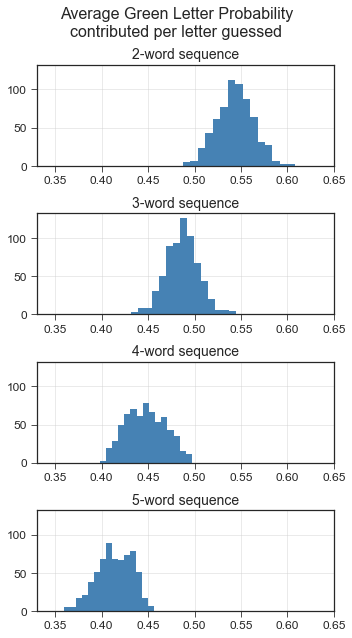

In [287]:
fig, ax = plt.subplots(nrows=4, sharey=True)
for i, num in enumerate(['2', '3', '4', '5']):
    ax[i].hist(df['mean_tglp'+num], bins=15, color='steelblue')
    ax[i].set_title(f'{num}-word sequence', fontsize=14)
    ax[i].set_xlim((0.33, 0.65))
    ax[i].tick_params(axis='both', which='major', labelsize=12)
    ax[i].grid(alpha=0.5)
fig.set_size_inches((5, 9))
fig.suptitle('Average Green Letter Probability\ncontributed per letter guessed', fontsize=16)
# fig.supylabel('count', fontsize=12)

fig.tight_layout()

# Same thing for log-likelihood of words instead of TGLP

In [222]:
ll_data = data.sort_values('wll', ascending=False)
ll_words = ll_data.index
ll_list = ll_data['wll'].to_list()
ll_results = []

ll_results = guess_sequence_search(word_list=ll_words,
                                     word_value=ll_list,
                                     results=ll_results, 
                                     priority_list=priority_list)

['sooey', 'brant', 'child', 'flump', 'gawks']
['saree', 'bliny', 'chout', 'gramp', 'fjeld']
['saine', 'borty', 'pluck', 'hewgh', 'fumed']
['soree', 'gaily', 'bundt', 'whack', 'frump']
['soare', 'bliny', 'dutch', 'frump', 'gawks']
['sease', 'crony', 'built', 'whump', 'faded']
['saice', 'drony', 'flump', 'bight', 'wokka']
['seine', 'coaly', 'brugh', 'tapet', 'fjord']
['cooee', 'slaty', 'brink', 'whump', 'gadid']
['seare', 'bliny', 'chout', 'faded', 'gopak']
['slane', 'pricy', 'fouth', 'baked', 'gemma']
['soole', 'briny', 'chapt', 'fumed', 'gawks']
['seise', 'coaly', 'brunt', 'whomp', 'faded']
['siree', 'coaly', 'bundt', 'whomp', 'griff']
['soily', 'crane', 'bumph', 'fated', 'wigga']
['cooey', 'saint', 'brugh', 'dwalm', 'pukka']
['soote', 'briny', 'cauld', 'khaph', 'gemma']
['saint', 'corey', 'flump', 'hewgh', 'kibbe']
['slate', 'crony', 'guimp', 'vozhd', 'wauff']
['slier', 'coady', 'thunk', 'gamme', 'bebop']
['saist', 'corey', 'blunk', 'whomp', 'fidge']
['slice', 'praty', 'bound', 'hewgh

['brant', 'soily', 'pudge', 'chowk', 'maxim']
['coact', 'shine', 'burly', 'faded', 'grump']
['feare', 'soily', 'bundt', 'chowk', 'grump']
['frier', 'slaty', 'bound', 'chowk', 'gamme']
['beaty', 'slink', 'courd', 'whomp', 'gaffe']
['price', 'slaty', 'bound', 'hewgh', 'kamik']
['carny', 'suite', 'whomp', 'fjeld', 'bobak']
['flane', 'soupy', 'chirt', 'baked', 'gemma']
['souct', 'brane', 'dimly', 'phizz', 'gawks']
['sasse', 'crony', 'built', 'whump', 'doved']
['maare', 'soily', 'bundt', 'chowk', 'gruff']
['boast', 'crine', 'plumy', 'hewgh', 'faded']
['poney', 'slart', 'quich', 'badge', 'mekka']
['savey', 'point', 'brugh', 'flack', 'dewax']
['prole', 'saint', 'fudgy', 'whack', 'bemix']
['chase', 'briny', 'poult', 'faded', 'skegg']
['belee', 'saint', 'crudy', 'whomp', 'quaff']
['bialy', 'souce', 'print', 'hewgh', 'faded']
['cruse', 'gaily', 'month', 'bided', 'spazz']
['snare', 'doily', 'butch', 'frump', 'gawks']
['salty', 'crine', 'bough', 'piped', 'flamm']
['blate', 'shiny', 'frock', 'muxed

['siren', 'coaly', 'bumph', 'twixt', 'fadge']
['roary', 'slice', 'bundt', 'whomp', 'gruff']
['touse', 'briny', 'chalk', 'faded', 'gemma']
['drole', 'saint', 'bumpy', 'whack', 'goffs']
['dairy', 'souce', 'plant', 'hewgh', 'vibex']
['ariel', 'stony', 'chump', 'badge', 'quaff']
['bousy', 'crane', 'glift', 'whomp', 'dazed']
['short', 'faine', 'bludy', 'crack', 'gompa']
['sadly', 'crine', 'fouth', 'begem', 'pukka']
['spree', 'coaly', 'quint', 'hewgh', 'fremd']
['arret', 'soily', 'chunk', 'badge', 'flamm']
['foley', 'saint', 'brugh', 'clack', 'whomp']
['teene', 'soily', 'brach', 'fumed', 'qapik']
['torse', 'gaily', 'chunk', 'bided', 'swamp']
['sonar', 'cluey', 'whipt', 'badge', 'quaff']
['frory', 'saine', 'mulct', 'vozhd', 'bebop']
['flier', 'soapy', 'bundt', 'chowk', 'gamme']
['farse', 'bliny', 'chout', 'domed', 'spazz']
['silly', 'crane', 'fouth', 'paged', 'bemix']
['trait', 'souce', 'glyph', 'djinn', 'baffy']
['dooce', 'slaty', 'brink', 'whump', 'gaffs']
['goosy', 'crane', 'built', 'whump

['teaed', 'soily', 'crunk', 'bumph', 'gaffe']
['tutee', 'soily', 'crank', 'whomp', 'bedad']
['parly', 'souce', 'think', 'bided', 'flamm']
['frere', 'soily', 'chant', 'puked', 'bemix']
['daint', 'souce', 'glyph', 'braky', 'immew']
['birse', 'coaly', 'thunk', 'faded', 'primp']
['guise', 'coaly', 'front', 'whump', 'baked']
['craal', 'shine', 'pouty', 'faded', 'bemix']
['suave', 'crony', 'glift', 'whump', 'boded']
['sabre', 'doily', 'chunk', 'tempt', 'graff']
['woose', 'briny', 'claut', 'humph', 'faded']
['brame', 'soily', 'chunk', 'tapet', 'fjord']
['spile', 'crony', 'ghaut', 'boded', 'kamik']
['blart', 'souce', 'whiny', 'faded', 'muzak']
['beery', 'saint', 'could', 'whomp', 'graff']
['reney', 'sault', 'hoick', 'budge', 'flamm']
['pratt', 'soily', 'bunce', 'hewgh', 'faded']
['shall', 'crine', 'pouty', 'faded', 'bemix']
['tarry', 'slice', 'bound', 'whomp', 'graff']
['shady', 'crine', 'boult', 'kamik', 'wigga']
['front', 'saice', 'bludy', 'khaph', 'gemma']
['waney', 'souct', 'dhikr', 'flamm

['thole', 'saury', 'boink', 'cided', 'gramp']
['trade', 'soily', 'chunk', 'begem', 'waffs']
['clade', 'shiny', 'grout', 'kopek', 'bemix']
['surge', 'coaly', 'think', 'faded', 'bebop']
['coach', 'suite', 'barny', 'flump', 'gived']
['mouse', 'briny', 'clapt', 'hewgh', 'faded']
['geese', 'coaly', 'print', 'fumed', 'bawks']
['coset', 'briny', 'fauld', 'whomp', 'skegg']
['party', 'slice', 'bound', 'hewgh', 'muzak']
['ferny', 'sault', 'hoick', 'budge', 'whomp']
['ponce', 'slaty', 'brugh', 'fiked', 'maxim']
['darre', 'soily', 'chunk', 'tempt', 'graff']
['druse', 'coaly', 'think', 'begem', 'waffs']
['birsy', 'coate', 'plunk', 'whiff', 'gaged']
['shill', 'crane', 'pouty', 'faded', 'bemix']
['suede', 'coaly', 'print', 'hewgh', 'kamik']
['curly', 'saine', 'fowth', 'bided', 'gramp']
['clame', 'shiny', 'grout', 'boded', 'qapik']
['dreer', 'soily', 'chant', 'flump', 'kibbe']
['slove', 'briny', 'chapt', 'fumed', 'gawks']
['grist', 'coaly', 'bunde', 'whomp', 'jeffs']
['morse', 'gaily', 'bundt', 'whack

['honey', 'slart', 'quick', 'badge', 'frump']
['danny', 'slice', 'broth', 'muzak', 'pouff']
['tride', 'soapy', 'clunk', 'hewgh', 'vibex']
['rhine', 'slaty', 'pubco', 'faded', 'gemma']
['brill', 'soave', 'punty', 'chowk', 'faded']
['meuse', 'coaly', 'print', 'faded', 'burgh']
['hairy', 'souce', 'plant', 'bided', 'muzak']
['perry', 'saint', 'could', 'brogh', 'flamm']
['roost', 'faine', 'bludy', 'whack', 'gemma']
['soupy', 'crane', 'glift', 'baked', 'whelm']
['burly', 'saine', 'compt', 'hewgh', 'fifed']
['deist', 'coaly', 'brung', 'whomp', 'viffs']
['blame', 'shiny', 'court', 'faded', 'wigga']
['beigy', 'slant', 'frock', 'whump', 'doved']
['groat', 'slice', 'bundy', 'whump', 'koffs']
['prent', 'soily', 'gauch', 'bided', 'flamm']
['pogey', 'saint', 'churl', 'buffe', 'dwalm']
['sited', 'coaly', 'brung', 'whomp', 'quiff']
['stilt', 'crane', 'podgy', 'bumph', 'wauff']
['platt', 'souce', 'briny', 'hewgh', 'faded']
['pence', 'soily', 'graft', 'muxed', 'chowk']
['surgy', 'coate', 'blind', 'whomp

In [252]:
lldf = []
for sequence in ll_results:
#     print(calc_summed_tglp_and_repeats(sequence[:-3])[1])
    lldf.append([*sequence, 
                *calc_tll_and_repeats(sequence),        
                *calc_tll_and_repeats(sequence[:-1]),
                *calc_tll_and_repeats(sequence[:-2]), 
                *calc_tll_and_repeats(sequence[:-3]),])
    

columns = ['w1', 'w2', 'w3', 'w4', 'w5', 
           'tll5', 'nu5', 
           'tll4', 'nu4',
           'tll3', 'nu3',
           'tll2', 'nu2']
lldf = pd.DataFrame(lldf, columns=columns)
for num in ['5','4','3','2']:
    lldf['mean_tll'+num] = lldf['tll'+num]/int(num)
    lldf['mean_tll_per_unique'+num] = lldf['tll'+num]/lldf['nu'+num]
# tglp# = total green letter probability with that many words in the sequence
# nu# = Number of Unique letters in that sequence 
# mean_tglp# = average Total green letter probability gained per letter (not unique letter!!)
lldf

,w1,w2,w3,w4,w5,tll5,nu5,tll4,nu4,tll3,...,tll2,nu2,mean_tll5,mean_tll_per_unique5,mean_tll4,mean_tll_per_unique4,mean_tll3,mean_tll_per_unique3,mean_tll2,mean_tll_per_unique2
0,sooey,brant,child,flump,gawks,-66.992100,21,-49.662284,18,-34.543853,...,-21.538189,9,-13.398420,-3.190100,-12.415571,-2.759016,-11.514618,-2.467418,-10.769095,-2.393132
1,saree,bliny,chout,gramp,fjeld,-66.819792,20,-49.157217,17,-34.773227,...,-21.764874,9,-13.363958,-3.340990,-12.289304,-2.891601,-11.591076,-2.483802,-10.882437,-2.418319
2,saine,borty,pluck,hewgh,fumed,-66.174259,21,-52.260973,18,-35.847989,...,-22.261901,10,-13.234852,-3.151155,-13.065243,-2.903387,-11.949330,-2.389866,-11.130950,-2.226190
3,soree,gaily,bundt,whack,frump,-64.244992,21,-49.409280,18,-35.577742,...,-21.959553,9,-12.848998,-3.059285,-12.352320,-2.744960,-11.859247,-2.541267,-10.979777,-2.439950
4,soare,bliny,dutch,frump,gawks,-68.216082,21,-50.886266,18,-36.050554,...,-21.954916,10,-13.643216,-3.248385,-12.721566,-2.827015,-12.016851,-2.403370,-10.977458,-2.195492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,waist,corey,blunk,humph,fidge,-66.597852,21,-52.821842,18,-36.566224,...,-23.355394,10,-13.319570,-3.171326,-13.205461,-2.934547,-12.188741,-2.437748,-11.677697,-2.335539
996,stair,coney,flump,hewgh,kibbe,-72.092560,20,-55.045872,18,-38.632888,...,-23.514458,10,-14.418512,-3.604628,-13.761468,-3.058104,-12.877629,-2.575526,-11.757229,-2.351446
997,shard,coney,built,gamme,pluff,-65.964357,19,-49.490988,17,-35.642395,...,-23.515068,10,-13.192871,-3.471808,-12.372747,-2.911235,-11.880798,-2.376160,-11.757534,-2.351507
998,doner,slaty,quich,gamme,bebop,-66.970757,19,-51.880893,17,-38.032300,...,-23.264966,10,-13.394151,-3.524777,-12.970223,-3.051817,-12.677433,-2.535487,-11.632483,-2.326497


In [282]:
print('Best 1st word guess according to log-likelihood:')
print(data['wll'].idxmax())
for num in ['2','3','4','5']:
    best = lldf['mean_tll_per_unique'+num].idxmax()
    print(f'Best {num}-word sequence according to log-likelihood:')
    print(lldf.loc[best, ['w1', 'w2', 'w3', 'w4', 'w5']].to_list()[:int(num)])

Best 1st word guess according to log-likelihood:
sooey
Best 2-word sequence according to log-likelihood:
['soily', 'crane']
Best 3-word sequence according to log-likelihood:
['shied', 'coaly', 'brunt']
Best 4-word sequence according to log-likelihood:
['plate', 'shiny', 'brock', 'fumed']
Best 5-word sequence according to log-likelihood:
['footy', 'saine', 'brugh', 'plack', 'meved']


In [275]:
np.log(np.array(list(bowcur['4'].values())) + 1/2315 )

array([-3.5727777 , -5.26225832, -4.28142906, -2.96804147, -1.6950758 ,
       -4.4513281 , -4.00949535, -2.80552254, -5.26225832, -7.74716497,
       -3.01096652, -2.69091916, -3.98596485, -2.87196764, -3.66962752,
       -3.7041137 , -7.74716497, -2.3858728 , -4.13624705, -2.2098307 ,
       -7.05401779, -7.74716497, -4.85679321, -5.54994039, -1.84726761,
       -6.13772705])

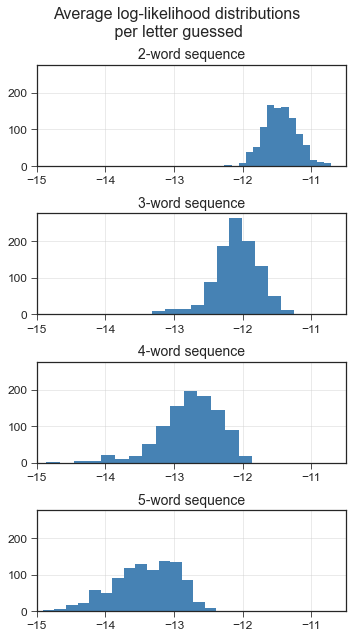

In [263]:
fig, ax = plt.subplots(nrows=4, sharey=True)
for i, num in enumerate(['2', '3', '4', '5']):
    ax[i].hist(lldf['mean_tll'+num], bins=15, color='steelblue')
    ax[i].set_title(f'{num}-word sequence', fontsize=14)
    ax[i].set_xlim((-15, -10.5))
    ax[i].tick_params(axis='both', which='major', labelsize=12)
    ax[i].grid(alpha=0.5)
fig.set_size_inches((5, 9))
fig.suptitle('Average log-likelihood distributions\n per letter guessed', fontsize=16)
# fig.supylabel('count', fontsize=12)

fig.tight_layout()
